In [1]:
import argparse
from ast import Param
from audioop import reverse
import os
import time
import csv
import torch
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.datasets as dset
# from cifar_10_1_dataset import load_new_test_data
from learning.wideresnet import WRN34_rot_out_branch
from utils import *
from RandAugment import trans_aug, get_transAug_param
from robustbench.utils import load_model
from robustbench.data import load_cifar10c
from torch.utils.data import Subset
import kornia
from imagecorruptions import corrupt
import matplotlib.pyplot as plt
%matplotlib inline
torch.cuda.set_device(3) 

In [2]:
mu = torch.tensor(cifar10_mean).view(3, 1, 1).cuda()
std = torch.tensor(cifar10_std).view(3, 1, 1).cuda()

In [3]:
class Batches:
    def __init__(self, dataset, batch_size, shuffle, set_random_choices=False, num_workers=0, drop_last=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.set_random_choices = set_random_choices
        self.data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True, shuffle=shuffle,
            drop_last=drop_last
        )

    def __iter__(self):
        if self.set_random_choices:
            self.dataset.set_random_choices()
        return ({'input': x.to(device).float(), 'target': y.to(device).long()} for (x, y) in self.data_loader)

    def __len__(self):
        return len(self.data_loader)

In [4]:
# transforms = [Crop(32, 32)]
dataset = cifar10("../cifar-data")

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                      'defocus_blur', 'motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']
    
corruption_type = ['motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']

train_set = list(zip(transpose(pad(dataset['train']['data'], 4) / 255.),
                         dataset['train']['labels']))
train_set_x = Transform(train_set, transforms)
print(len(train_set_x))
train_batches = Batches(train_set_x, 1, shuffle=True, set_random_choices=True, num_workers=2)

test_set = list(zip(transpose(dataset['test']['data'] / 255.), dataset['test']['labels']))
print(len(test_set))
test_batches = Batches(test_set, 10000, shuffle=False, num_workers=2)


In [6]:
from PIL import Image

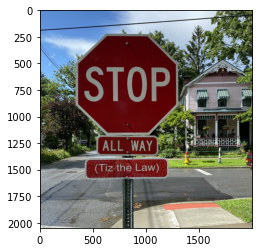

(2048, 2000, 3)


In [12]:
orig_img = Image.open('./figs/image.png')
plt.imshow(orig_img)
plt.show()
orig_np = np.asarray(orig_img)
print(orig_np.shape)

In [ ]:
# corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
#                     'defocus_blur', 'motion_blur' , 'glass_blur', 'zoom_blur',
corruption_type=['snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                     'pixelate', 'jpeg_compression']

severity = [5]
for c in corruption_type:
    for s in severity:
        file_name = c + '_s' + str(s) + '.png' 
        print(file_name)
        corr_img = corrupt(orig_np, corruption_name=c, severity=s)
        plt.imshow(corr_img)
        plt.axis('off')
        plt.savefig(os.path.join('./figs', file_name), bbox_inches='tight', pad_inches=0, dpi=400)

snow_s5.png
frost_s5.png
fog_s5.png
brightness_s5.png
contrast_s5.png
elastic_transform_s5.png
pixelate_s5.png
jpeg_compression_s5.png


In [ ]:
from robustbench.data import load_cifar10c, load_imagenetc
path = '/local/rcs/yunyun/'
corruption_type = ['gaussian_blur']
x_test, y_test = load_imagenetc(10000, 1, path, False, corruption_type)

In [ ]:
import socket
import torchvision.datasets as datasets

if 'thor' in socket.gethostname():
        traindir='/local/rcs/yunyun/ImageNet-Data/train'
        valdir='/local/rcs/yunyun/ImageNet-Data/val'

imgnet_mean=(0.485, 0.456, 0.406)
imgnet_std=(0.229, 0.224, 0.225)

train_dataset = datasets.ImageFolder(
            traindir,
            transforms.Compose([
                transforms.Resize(64), transforms.CenterCrop(64),
                transforms.ToTensor(), ]))#transforms.Normalize(imgnet_mean, imgnet_std),]))

test_dataset = datasets.ImageFolder(
                valdir,
                transforms.Compose([
                    transforms.Resize(64), transforms.CenterCrop(64),
                    transforms.ToTensor(),])) #transforms.Normalize(imgnet_mean, imgnet_std),]))

In [ ]:
class_keys = ['n01443537', 'n01494475', 'n01496331', 'n01498041', 
            'n01514859' , 'n01518878', 'n01531178', 'n01532829', 'n01534433', 'n01537544']
    
train_class_idx = [train_dataset.class_to_idx[k] for k in class_keys]
test_class_idx = [test_dataset.class_to_idx[k] for k in class_keys]
print(train_class_idx)
print(test_class_idx)


train_idx = [torch.tensor(train_dataset.targets) == i for i in train_class_idx]
test_idx = [torch.tensor(test_dataset.targets) == i for i in test_class_idx]


train_mask = train_idx[0]
for i in range(1, len(train_idx)): train_mask = train_mask | train_idx[i]
test_mask = test_idx[0]
for i in range(1, len(test_idx)): test_mask = test_mask | test_idx[i]

train_indices = train_mask.nonzero().reshape(-1)   
test_indices = test_mask.nonzero().reshape(-1)

train_subdatasets = Subset(train_dataset, train_indices)
test_subdatasets = Subset(test_dataset, test_indices)

relabel_testsets = []
h = []
for i in range(len(test_subdatasets)):
    relabel_testsets.append([test_subdatasets[i][0], test_class_idx.index(test_subdatasets[i][1])])
    h.append(test_class_idx.index(test_subdatasets[i][1]))

In [ ]:
test_loader = Batches(relabel_testsets, 1, shuffle=False, num_workers=2)
file_path = './data/ImageNetC-10cls-ds64/' 
orig_img = []
for i, data in enumerate(test_loader):
    x = data['input']
    y = data['target']
    img = np.transpose(np.array(torch.squeeze(x[0], 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
    orig_img.append(img)
        
with open(file_path + 'original.npy', 'wb') as f:
    print('save original test image to : {}'.format(file_path + 'original.npy'))
    np.save(f, np.array(orig_img))

In [10]:
orig_imgs = np.load('./data/ImageNetC-10cls-ds64/original.npy')
print(orig_imgs.shape)
orig_np = numpy.asarray(orig_imgs)

FileNotFoundError: [Errno 2] No such file or directory: './data/ImageNetC-10cls-ds64/original.npy'

In [ ]:

corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                    'defocus_blur', 'motion_blur' , 'glass_blur', 'zoom_blur',
                     'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                     'pixelate', 'jpeg_compression']

severity = [1,2,3,4,5]

for s in severity:
    for corruption in corruption_type:
        file_path = './data/ImageNetC-10cls-ds64/'+ str(s) + '/' + corruption + '.npy'
        corr_img = []
        count = 0
        for i, data in enumerate(test_loader):
            x = data['input']
            y = data['target']
            npx = np.transpose(np.array(torch.squeeze(x[0], 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
            corrupted_image = corrupt(npx, corruption_name=corruption, severity=s)
            corr_img.append(corrupted_image)
            count+=1
        print(np.array(corr_img).shape)
        with open(file_path, 'wb') as f:
            print('save corrupted image to : {}'.format(file_path))
            np.save(f, np.array(corr_img))
    

In [ ]:
orig_imgs = np.load('./data/ImageNetC-10cls-ds64/original.npy')

# plt.title('without normalize')
plt.axis('off')
# img=normalise(corr_img, imgnet_mean, imgnet_std)
img0 = orig_imgs[499]/ 255.


plt.imshow(img0)
plt.show()
for i in range(1,2):
    corr_imgs = np.load('./data/ImageNetC-10cls-ds64/' + str(i)  + '/gaussian_noise.npy')
    img1= corr_imgs[499]/ 255.
    plt.axis('off')
    plt.imshow(img1)
    plt.show()
# plt.title('with normalize')

plt.show()

In [ ]:

test_dataset
h = []
for i in range(len(test_dataset)):
    if i % 50 <5:
        h.append(test_dataset.targets[i])
print(h)


In [3]:
root_path = '/local/rcs/yunyun/SelfSupDefense-random-experiments/data/ImageNetC-customize/'
original_file = np.load(root_path + 'original.npy')
print(original_file.shape)

(50000, 224, 224, 3)


In [7]:

# 0-4 5-9 10-14 15-19 20-24 25-29 30-34 35-39
# 0-49 50-99 100-149 150-199 200-249 250-299 300-349 350-399 
# frost_5_img_167_pred_793-33_param_1.47
corruption_file = np.load(root_path + 'reversed/saturation/frost_5_img_8_pred_327-1_param_1.47.npy', allow_pickle=True)
# corruption_file = np.load(root_path + 'reversed/saturation/frost_5_img_167_pred_793-33_param_1.47', allow_pickle=True)

# n02483708 n01608432

In [8]:
imgnet_mean=(0.485, 0.456, 0.406)
imgnet_std=(0.229, 0.224, 0.225)
def normalise(x, mean, std):
    x, mean, std = [np.array(a, np.float32) for a in (x, mean, std)]
    x -= mean * 255
    x *= 1.0 / (255 * std)
    return x

(2, 224, 224, 3)


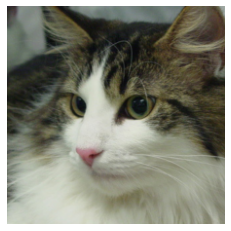

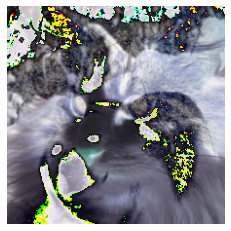

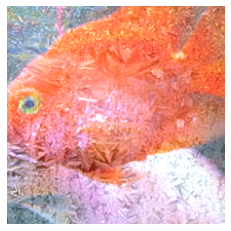

In [121]:
print(corruption_file.shape)
corr_img = corruption_file[0]
rev_img = corruption_file[1]
ori_img = original_file[14062]


# npx = np.transpose(np.array(torch.squeeze(ori_img, 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
# corrupt_image = corrupt(ori_img, corruption_name='brightness', severity=3)

# plt.title('without normalize')
plt.axis('off')
# img=normalise(corr_img, imgnet_mean, imgnet_std)
img0 = ori_img/ 255.
img1= (corrupt_image-ori_img)/ 255.
img2 = rev_img/ 255.
plt.imshow(img0)
plt.show()
plt.axis('off')
plt.imshow(img1)
plt.show()
# plt.title('with normalize')
plt.imshow(img2)
plt.axis('off')
plt.show()


In [34]:
def apply_pixelate(x, severity=1):
    c = [0.6, 0.5, 0.4, 0.3, 0.25][severity - 1]

    x_shape = np.array(x).shape

    x = x.resize((int(x_shape[1] * c), int(x_shape[0] * c)), Image.BOX)
    print(np.uint8(x).shape)
    plt.title('downsampling resize')
    plt.axis('off')
    plt.imshow(np.uint8(x))
    plt.show()
    x = x.resize((x_shape[1], x_shape[0]), Image.NEAREST)
    plt.title('upsampling resize')
    plt.axis('off')
    plt.imshow(np.uint8(x))
    plt.show()
    return np.uint8(x)

In [ ]:
test_ref = next((iter(test_batches)))
print(test_ref['input'][0].shape)
data_dir = './data/'
np_image = np.load(data_dir + 'original.npy')
print(np_image[0].shape)
x = test_ref['input'][0]
x0 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x0).shape)
plt.title('original')
plt.axis('off')
plt.imshow(np.uint8(x0))
plt.show()
x_shape = test_ref['input'][0].shape
transform = torch.nn.Sequential(transforms.Resize(size=int(x_shape[1]*0.5), interpolation=Image.BILINEAR),)
x = transform(x)
x1 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x1).shape)
plt.title('downsampling resize')
plt.axis('off')
plt.imshow(np.uint8(x1))
plt.show()
transform = torch.nn.Sequential(transforms.Resize(size=x_shape[1], interpolation=Image.NEAREST),)
x = transform(x)
x2 = np.transpose(np.array((x.detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
print(np.uint8(x2).shape)
plt.title('upsampling resize')
plt.axis('off')
plt.imshow(x2)
plt.show()
# print(x.shape)
# x = np.transpose(np.array((test_ref['input'][0].detach().cpu().numpy())*255, dtype=np.uint8), (1,2,0))
# print(np_image[0].shape)
# plt.title('Original')
# plt.axis('off')
# plt.imshow(np_image[0])
# plt.show()
# px = apply_pixelate(Image.fromarray(np_image[0]), 1)
#px = corrupt(np_image[0], corruption_name='pixelate', severity=1)
# print(px.shape)
# with open('original.npy', 'wb') as f:
#     np.save(f, np_image)

In [ ]:
original_img_array = np.load('./data/original.npy')
print(original_img_array.shape)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from RandAugment import trans_aug, get_transAug_param
np_image = np.load('./pixelate_test_compare.npy', allow_pickle=True)
corrupted_img_array = np.load('./data/CIFAR-10-C-customize/pixelate.npy')
#np_image = np.transpose(np_image, (1,0,2,3))
idx = np_image[0]
before_imgs = np_image[1]
reverse_imgs = np_image[2]
aug_method = np_image[3]
aug_param = np_image[4]
print(aug_method, aug_param.item())
o_img = original_img_array[idx*64:(idx+1)*64]
for i in range(np_image[1].shape[0]):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6), sharex=False, sharey=False) 
    fig.tight_layout()
    ax = axes.ravel()
#     corr = np.transpose(before_imgs[i], (1,2,0))
    reverse = np.transpose(reverse_imgs[i], (1,2,0))
    corr = np.transpose(before_imgs[i], (1,2,0))
    
    ax[0].imshow(o_img[i])
    ax[0].set_title('orig')
    
#     corr = RandAugment.trans_aug(aug_method, torch.tensor(np.expand_dims(np.transpose(o_img[i]/255, (2,0,1)), axis=0)) , aug_param)
#     corr = np.transpose(np.array(torch.squeeze(corr, 0).detach().cpu().numpy()*255, dtype=np.uint8), (1,2,0))
    ax[1].imshow(corr)
    ax[1].set_title('corruption: pixelate')
#   ax[1].set_xlabel('param: '+ aug_method + ' {0:0.3f}'.format(aug_param.item()))


    ax[2].imshow(reverse)
    ax[2].set_title('reverse \n best param: '+ aug_method + ' {0:0.3f}'.format(aug_param.item()))
    cosim = cos_sim(o_img[i].ravel().reshape(1,-1), reverse.ravel().reshape(1,-1))[0][0]
    ax[2].set_xlabel('cosine similarity:{0:0.5f}'.format(cosim))
    
    
    plt.show()

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd

(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 10)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)
(2, 100, 2)


/tmp/ipykernel_60895/1283349535.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = data_list[3].append(data_list[4]).append(data_list[5]).append(data_list[6])
/tmp/ipykernel_60895/1283349535.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = data_list[3].append(data_list[4]).append(data_list[5]).append(data_list[6])
/tmp/ipykernel_60895/1283349535.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(axes[i].get_yticks(), fontsize=18)
/tmp/ipykernel_60895/1283349535.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = data_list[3].append(data_list[4]).append(data_list[5]).append(data_list[6])
/tmp/ipykernel_60895/1283349535.py:19: FutureWarning: The fr

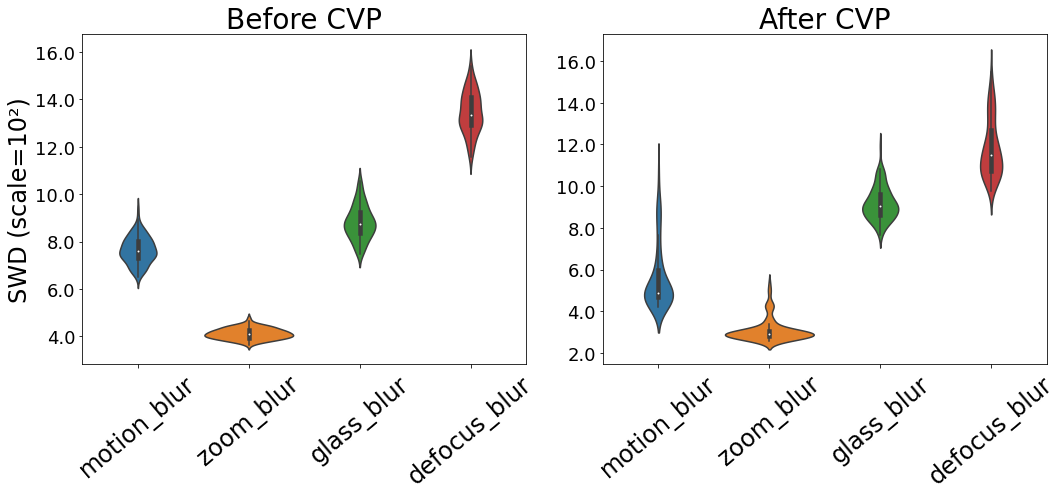

In [40]:
corr_list = ['gaussian_noise', 'impulse_noise', 'shot_noise', 'motion_blur', 'zoom_blur', 'glass_blur', 'defocus_blur',
            'brightness', 'snow', 'frost', 'fog', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7), sharex=False, sharey=False) 
for i in range(2):
    data_list = []
    for j in range(len(corr_list)):
        swd_array = np.load('./output/swd/' + corr_list[j]+'_s1.npy', allow_pickle=True)
        print(swd_array.shape)
        if i == 0:
            swd = swd_array[0]/100
        else:
            swd = swd_array[1]/100
        d = pd.DataFrame({ 'Corruption' : np.repeat(corr_list[j], 100), 'SWD': swd[:,0]})
        data_list.append(d)

#     df = data_list[0].append(data_list[1]).append(data_list[2]).append(data_list[3]).append(data_list[4]).append(data_list[5]).append(data_list[6]).append(data_list[7]).append(data_list[8]).append(data_list[9]).append(data_list[10]).append(data_list[11]).append(data_list[12]).append(data_list[13]).append(data_list[14])
    
    df = data_list[3].append(data_list[4]).append(data_list[5]).append(data_list[6])

    if i==0:
        axes[i].set_title('Before CVP', fontsize=28)
    else:
        axes[i].set_title('After CVP', fontsize=28)
    # plot violin chart

    b = sns.violinplot(ax=axes[i], x='Corruption', y='SWD', data=df)

    for tick in axes[i].get_xticklabels():
        tick.set_rotation(40)
        
    axes[i].set_xlabel('')
    axes[i].set_ylabel('SWD (scale=10\u00b2)', fontsize=24)
    if i == 1:
        axes[i].set_ylabel('')
    axes[i].set_yticklabels(axes[i].get_yticks(), fontsize=18)
    axes[i].set_xticklabels(['motion_blur', 'zoom_blur', 'glass_blur', 'defocus_blur'], fontsize=24)

        
   
    # add title
# plt.title("Violin plot", loc="left")
    # show the graph
plt.tight_layout()
plt.savefig('./output/swd_blur_type.png', dpi=200)

In [3]:
corr_list = ['gaussian_noise', 'impulse_noise', 'shot_noise', 'motion_blur', 'zoom_blur', 'glass_blur', 'defocus_blur',
            'brightness', 'snow', 'frost', 'fog', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']
for i in range(len(corr_list)):
    swd_array = np.load('./output/swd/' + corr_list[i]+'_s1.npy', allow_pickle=True)

    before_swd = swd_array[0]/100
    after_swd = swd_array[1]/100
    
    print(before_swd.shape)
    print(after_swd.shape)
    avg_before_swd = [before_swd[:, j].mean() for j in range(before_swd.shape[1])]
    avg_after_swd = [after_swd[:,j].mean() for j in range(after_swd.shape[1])]
    print('corr: ', corr_list[i], 'before swd: ', np.array(avg_before_swd).mean(), 'avg_after_swd: ', np.array(avg_after_swd).mean())

(100, 10)
(100, 10)
corr:  gaussian_noise before swd:  5.897996 avg_after_swd:  4.7146635
(100, 10)
(100, 10)
corr:  impulse_noise before swd:  6.229506 avg_after_swd:  5.260451
(100, 10)
(100, 10)
corr:  shot_noise before swd:  6.077535 avg_after_swd:  4.928255
(100, 10)
(100, 10)
corr:  motion_blur before swd:  7.6755157 avg_after_swd:  5.574033
(100, 10)
(100, 10)
corr:  zoom_blur before swd:  4.1319323 avg_after_swd:  3.093947
(100, 10)
(100, 10)
corr:  glass_blur before swd:  8.849164 avg_after_swd:  9.191797
(100, 10)
(100, 10)
corr:  defocus_blur before swd:  13.522902 avg_after_swd:  11.816455
(100, 10)
(100, 10)
corr:  brightness before swd:  2.483415 avg_after_swd:  3.9394279
(100, 2)
(100, 2)
corr:  snow before swd:  5.1751814 avg_after_swd:  6.0745234
(100, 2)
(100, 2)
corr:  frost before swd:  7.6116543 avg_after_swd:  7.7208867
(100, 2)
(100, 2)
corr:  fog before swd:  13.48789 avg_after_swd:  9.985085
(100, 2)
(100, 2)
corr:  contrast before swd:  15.394927 avg_after_swd

(2, 625)
2.86 0.64
3.43 0.69


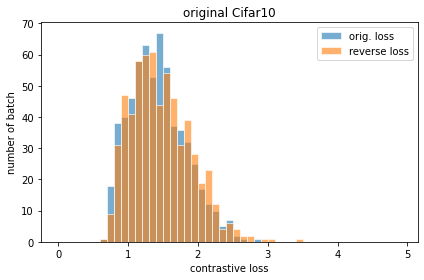

In [4]:
loss_list = np.load('./loss_histogram/cifar10c_orig.npy', allow_pickle=True)
print(loss_list.shape)
orig_loss = np.round(loss_list[0],2)
# corr_loss = loss_list[1]
reverse_loss = np.round(loss_list[1],2)
print(orig_loss.max(), orig_loss.min())
# print(corr_loss.max(), corr_loss.min())
print(reverse_loss.max(), reverse_loss.min())


import matplotlib.pyplot as plt 
plt.hist(orig_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='orig. loss')
plt.hist(reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='reverse loss')
plt.title('original Cifar10')
plt.xlabel('contrastive loss')
plt.ylabel('number of batch')
plt.legend()
plt.tight_layout()
plt.show()

5.36 2.72
5.26 2.27


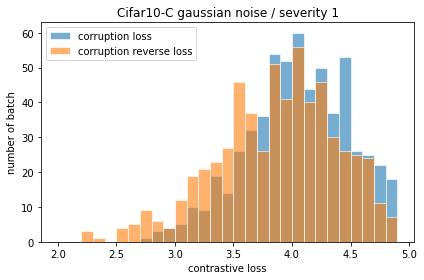

In [5]:
severity = [1]
for s in severity:
    loss_list = np.load('./loss_histogram/cifar10c_ours_fog_s2_ai5.npy', allow_pickle=True)
    corrupt_loss = np.round(loss_list[0],2)
    # corr_loss = loss_list[1]
    corrupt_reverse_loss = np.round(loss_list[1],2)
    print(corrupt_loss.max(), corrupt_loss.min())
    # print(corr_loss.max(), corr_loss.min())
    print(corrupt_reverse_loss.max(), corrupt_reverse_loss.min())

#     plt.hist(orig_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='orig. loss')
    plt.hist(corrupt_loss, bins=np.arange(20,50)/10, edgecolor="white",alpha = 0.6, label='corruption loss')
    plt.hist(corrupt_reverse_loss, bins=np.arange(20,50)/10, edgecolor="white",alpha = 0.6, label='corruption reverse loss')
    plt.title('Cifar10-C gaussian noise / severity ' + str(s))
    plt.xlabel('contrastive loss')
    plt.ylabel('number of batch')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [105]:
acc_list = []
loss_list = []
counter  = 0.
with open('./cifarc_result/cifar10c_loss_acc_result.csv', 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if counter %3 == 0 and counter < 9:
            acc_list.append(float(row[9]))
            loss_list.append(float(row[11]))
        if counter %3 <= 2 and counter < 9:
            acc_list.append(float(row[10]))
            loss_list.append(float(row[12]))
        counter += 1
acc_list.append(0.9478)
loss_list.append(1.24)
print(acc_list)
print(loss_list)

[0.3951, 0.3963, 0.5109, 0.561, 0.1478, 0.1477, 0.1798, 0.1829, 0.1157, 0.1159, 0.118, 0.123, 0.9478]
[3.1701589836120605, 3.1539967195510865, 2.897934539985657, 2.6756519721984864, 3.9612640895843505, 3.954959186553955, 3.813786937713623, 3.6234266185760498, 4.118201085662842, 4.1167423534393315, 4.0831516826629635, 4.0103576934814456, 1.24]


In [128]:
line1_x = [0.3951, 0.3963, 0.5109, 0.561, 0.9478]
line1_y = [3.1701589836120605, 3.1539967195510865, 2.897934539985657, 2.6756519721984864, 1.24]

line2_x = [0.1478, 0.1477, 0.1798, 0.1829, 0.9478]
line2_y = [3.9612640895843505, 3.954959186553955, 3.813786937713623, 3.6234266185760498, 1.24]

line3_x = [0.1157, 0.1159, 0.118, 0.123, 0.9478]
line3_y = [4.118201085662842, 4.1167423534393315, 4.0831516826629635, 4.0103576934814456, 1.24]

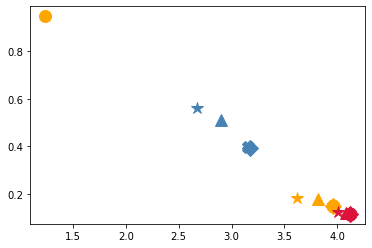

In [130]:
# plt.bar(br_list[0], tent_result, color=colors['black'], width = barWidth, label=label_list[0])
c = ['corrupted.', 'l2 only', 'Conv. prompt (iter 1)', 'Conv. prompt (iter 5)', 'original']

marker = ['D', 'X', '^', '*', 'o']
for i in range(len(line1_x)):
    plt.plot(line1_y[i], line1_x[i], marker[i], label=c[i], markersize=12, color=colors['steelblue'])
for i in range(len(line2_x)):
    plt.plot(line2_y[i], line2_x[i], marker[i], label=c[i], markersize=12, color=colors['orange'])
for i in range(len(line1_x)):
    plt.plot(line3_y[i], line3_x[i], marker[i], label=c[i], markersize=12, color=colors['crimson'])
# plt.bar(br_list[1], l2_result, color=colors['steelblue'], width = barWidth, label=label_list[1])
# plt.plot(line2_y, line2_x, '-',  marker='o', color=colors['steelblue'], linewidth=2)
# plt.bar(br_list[2], conv_result, color=colors['crimson'], width = barWidth, label=label_list[2])
# plt.plot(line3_y, line3_x, '-',  marker='*', color=colors['crimson'], linewidth=2)
# plt.bar(br_list[3], result[3], color=colors['gray'], width = barWidth, label=label_list[3])
# plt.plot(br_list[3], result[3], '--', color=colors['gray'], linewidth=2)

In [92]:
loss_file_list = ['./loss_histogram/ssl_loss/imnetc_gaussian_noise_s', 
                  './loss_histogram/ssl_loss/imnetc_defocus_blur_s', 
                 './loss_histogram/ssl_loss/imnetc_snow_s',
                 './loss_histogram/ssl_loss/imnetc_contrast_s']
corruption_name = ['Gaussian Noise', 'Defocus Blur', 'Snow', 'Contrast']

loss_list = np.load('./loss_histogram/ssl_loss/imnetc_orig.npy', allow_pickle=True)
print(loss_list.shape)
orig_loss = np.round(loss_list[0],2)
orig_loss[0].mean()

(2, 625)


1.24

(625,)
3.29 0.93
(625,)
3.43 1.22
(625,)
3.43 1.43
(625,)
3.48 1.84
(625,)
3.66 2.38
Gaussian Noise
(625,)
4.29 2.5
(625,)
4.31 2.64
(625,)
4.34 2.76
(625,)
4.36 2.67
(625,)
4.43 2.67
Defocus Blur
(625,)
4.13 2.46
(625,)
4.48 2.85
(625,)
4.5 2.96
(625,)
4.62 3.05
(625,)
4.82 3.13
Snow
(625,)
4.05 1.66
(625,)
4.02 1.78
(625,)
4.12 1.88
(625,)
4.17 2.15
(625,)
4.09 2.28
Contrast


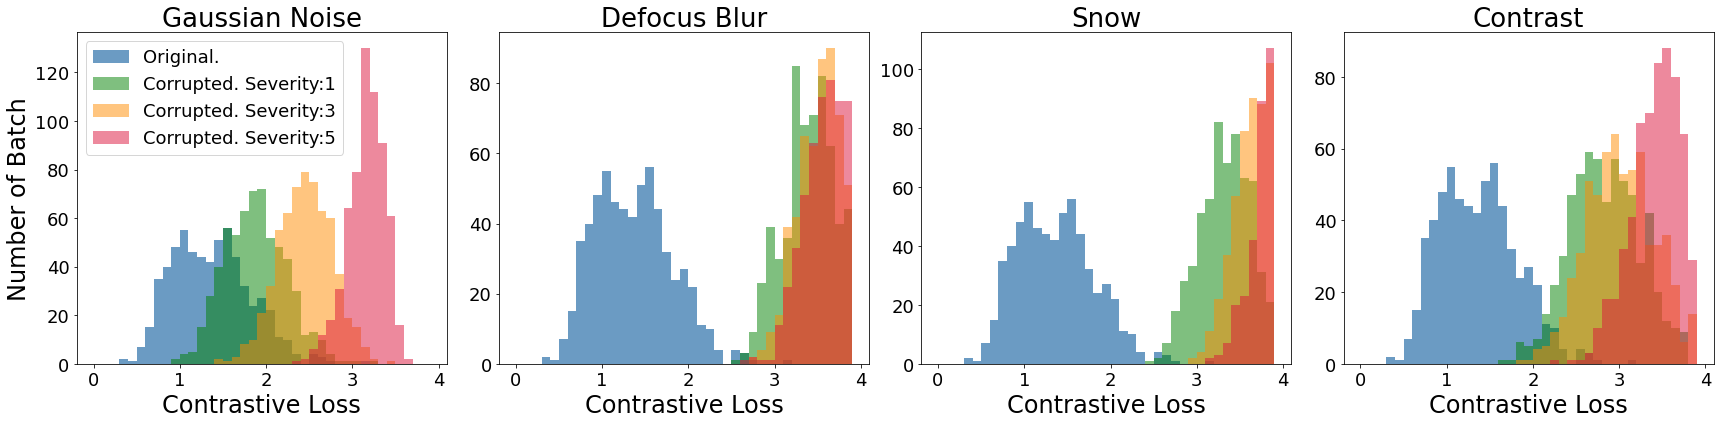

In [38]:
from matplotlib import colors as mcolors
severity = [1,2,3,4,5]
hatch_list = ['+', '/', '.', '/',  '/']
c_list = ['green', 'blue', 'darkorange', 'blue', 'crimson']
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
fig, axs = plt.subplots(1, 4, figsize=(24, 6))  
for i in range(len(loss_file_list)):
    corrupt_loss_list = []
    for s in severity:
        loss_list = np.load(loss_file_list[i] + str(s) +'.npy', allow_pickle=True)
        corrupt_loss = np.round(loss_list[0],2)
        print(corrupt_loss.shape)
        corrupt_loss_list.append(corrupt_loss)
        # corr_loss = loss_list[1]
        # corrupt_reverse_loss = np.round(loss_list[1],2)
        # print(corrupt_loss.max(), corrupt_loss.min())
        print(corrupt_loss.max(), corrupt_loss.min())
#         print(corrupt_reverse_loss.max(), corrupt_reverse_loss.min())

    axs[i].hist(orig_loss, bins=np.arange(40)/10, histtype='stepfilled', alpha = 0.8, label='Original.', color=colors['steelblue'])
    for s in [1,3,5]:
#         axs[i].hist(corrupt_loss_list[s-1], bins=np.arange(40)/10, histtype='stepfilled' , label=f'Corrupted. Severity:{s}', hatch=hatch_list[s-1])
          axs[i].hist(corrupt_loss_list[s-1], bins=np.arange(40)/10, histtype='stepfilled', alpha = 0.5 , label=f'Corrupted. Severity:{s}', color=colors[c_list[s-1]])
#     plt.hist(corrupt_reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption reverse loss')
    print(corruption_name[i])
    axs[i].tick_params(axis='both', which='major', labelsize=18)
    axs[i].set_title(f'{corruption_name[i]}', fontsize=26)
    axs[i].set_xlabel('Contrastive Loss', fontsize=24)
    
    if i==0:
        axs[i].legend(loc='upper left', fontsize=18)
        axs[i].set_ylabel('Number of Batch', fontsize=24)
               
plt.tight_layout()
plt.savefig('./output/imagnetc_loss_histogram.png', dpi=200)

In [23]:
severity = [1,2,3,4,5]
hatch_list = ['+', '/', '.', '/',  '/']
corrupt_loss_list = []
for s in severity:
    loss_list = np.load('./loss_histogram/imnetc_defocus_blur_s' + str(s) +'.npy', allow_pickle=True)
    corrupt_loss = np.round(loss_list[0],2)
    print(corrupt_loss.shape)
    corrupt_loss_list.append(corrupt_loss)
    # corr_loss = loss_list[1]
    # corrupt_reverse_loss = np.round(loss_list[1],2)
    # print(corrupt_loss.max(), corrupt_loss.min())
    # print(corr_loss.max(), corr_loss.min())
#     print(corrupt_reverse_loss.max(), corrupt_reverse_loss.min())

plt.hist(orig_loss, bins=np.arange(40)/10, histtype='stepfilled', alpha = 0.6, label='original loss')
for s in [1,3,5]:
    plt.hist(corrupt_loss_list[s-1], bins=np.arange(40)/10, histtype='step', alpha = 0.9, label=f'corrupted loss s{s}', hatch=hatch_list[s-1])
#     plt.hist(corrupt_reverse_loss, bins=np.arange(50)/10, edgecolor="white",alpha = 0.6, label='corruption reverse loss')
plt.title('ImageNet-C Defocus Blur')
plt.xlabel('contrastive loss')
plt.ylabel('number of batch')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './loss_histogram/imnetc_defocus_blur_s1.npy'

In [ ]:
loss_list = np.load('./loss_histogram/gaussiannoise_loss_hitogram.npy', allow_pickle=True)
loss_list = np.transpose(loss_list, (1,0))
print(loss_list.shape)
orig_loss = loss_list[0]
corr_loss = loss_list[1]
reverse_loss = loss_list[2]
print(orig_loss.max(), orig_loss.min())
print(corr_loss.max(), corr_loss.min())
print(reverse_loss.max(), reverse_loss.min())

print(np.sort(loss_list[0]*100))
bin_orig_loss = loss_list[0]*100//2
bin_corr_loss = loss_list[1]*100//2
bin_reverse_loss = loss_list[2]*100//2
print(bin_reverse_loss.min(), bin_reverse_loss.max())
print(bin_corr_loss.min(), bin_corr_loss.max())
print(bin_orig_loss.min(), bin_orig_loss.max())

In [8]:
filepath_list = ['./cifarc_result/cifar10c_compare_batch_rand3.csv', 
                 './cifarc_result/cifar10c_compare_batch_lnorm_only.csv',]

result = []
orig_result = []
for f in filepath_list:
    print(f)
#     corr1_list = []
#     corr2_list = []
#     orig_list = []
#     corr3_list = []
#     corr4_list = []
#     corr5_list = []
    counter = 0
    corr1, corr2, corr3, corr4, corr5 = 0,0,0,0,0
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if counter % 5 == 0:
                corr1 += float(row[10])*100
            elif counter % 5 == 1:
                corr2 += float(row[10])*100
            elif counter % 5 == 2:
                corr3 += float(row[10])*100
            elif counter % 5 == 3:
                corr4 += float(row[10])*100
            elif counter % 5 == 4:
                corr5 += float(row[10])*100
#             if counter % 5 == 0 and counter//5 >=11 and counter//5<=14:
#                 orig_list.append((float(row[8]))*100)
            counter += 1
        result.append([corr1/15, corr2/15, corr3/15, corr4/15, corr5/15])

./cifarc_result/cifar10c_compare_batch_rand3.csv
./cifarc_result/cifar10c_compare_batch_lnorm_only.csv


In [9]:
conv_result, l2_result = result


In [10]:
conv_result

[71.53266666666666,
 65.51866666666666,
 66.83333333333334,
 67.62533333333333,
 67.86800000000001]

In [11]:
counter = 0
corr1, corr2, corr3, corr4, corr5 = 0,0,0,0,0
result = []
with open('./cifarc_result/cifar10c_compare_batch_rand3.csv', 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        if counter % 5 == 0:
            corr1 += float(row[9])*100
        elif counter % 5 == 1:
            corr2 += float(row[9])*100
        elif counter % 5 == 2:
            corr3 += float(row[9])*100
        elif counter % 5 == 3:
            corr4 += float(row[9])*100
        elif counter % 5 == 4:
            corr5 += float(row[9])*100
#             if counter % 5 == 0 and counter//5 >=11 and counter//5<=14:
#                 orig_list.append((float(row[8]))*100)
        counter += 1
    result.append([corr1/15, corr2/15, corr3/15, corr4/15, corr5/15])

In [12]:
orig_result = result
print(orig_result)

[[62.30933333333333, 59.67533333333333, 59.67533333333333, 59.67533333333333, 59.67533333333333]]


In [13]:
filepath_list = ['./cifarc_result/cifar10c_batch_acc_l2_append.csv',
                './cifarc_result/cifar10c_batch_acc_all_finetune.csv']

result = []
orig_result = []
for f in filepath_list:
    print(f)
#     corr1_list = []
#     corr2_list = []
#     orig_list = []
#     corr3_list = []
#     corr4_list = []
#     corr5_list = []
    counter = 0
    corr1, corr2, corr3, corr4, corr5 = 0,0,0,0,0
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            print(row[10])
            if counter % 5 == 0:
                corr1 += float(row[10])*100
            elif counter % 5 == 1:
                corr2 += float(row[10])*100
            elif counter % 5 == 2:
                corr3 += float(row[10])*100
            elif counter % 5 == 3:
                corr4 += float(row[10])*100
            elif counter % 5 == 4:
                corr5 += float(row[10])*100
#             if counter % 5 == 0 and counter//5 >=11 and counter//5<=14:
#                 orig_list.append((float(row[8]))*100)
            counter += 1
        result.append([corr1/15, corr2/15, corr3/15, corr4/15, corr5/15])

./cifarc_result/cifar10c_batch_acc_l2_append.csv
0.3964
0.396
0.3957
0.3954
0.3952
0.3875
0.3874
0.3872
0.3871
0.3865
0.5796
0.5787
0.5784
0.5785
0.5783
0.3719
0.3722
0.3736
0.3724
0.3721
0.1616
0.1614
0.1618
0.1619
0.1612
0.8452
0.8452
0.8452
0.8457
0.8454
0.567
0.5669
0.5661
0.5665
0.5662
0.8755
0.8759
0.8762
0.8762
0.8761
0.8905
0.8906
0.8908
0.8906
0.8904
0.8237
0.8236
0.8236
0.824
0.8235
0.9439
0.9444
0.9439
0.9442
0.9439
0.8963
0.897
0.8977
0.8974
0.8975
0.3678
0.3677
0.3678
0.3671
0.3676
0.6031
0.6033
0.6032
0.603
0.6035
0.2269
0.2356
0.2361
0.2461
0.2460
0.4862
0.4996
0.5026
./cifarc_result/cifar10c_batch_acc_all_finetune.csv
0.3141
0.3551
0.3843
0.4062
0.4095
0.3036
0.348
0.38
0.4056
0.4288
0.3194
0.3625
0.3834
0.3958
0.4004
0.2193
0.2375
0.2594
0.2758
0.2685
0.1694
0.1727
0.1692
0.1704
0.1656
0.4156
0.4535
0.4724
0.4994
0.5
0.3485
0.3939
0.419
0.4358
0.4429
0.4803
0.5205
0.5083
0.5006
0.4757
0.5277
0.5794
0.5915
0.5869
0.5638
0.4628
0.5057
0.5192
0.5258
0.5219
0.5747
0.6105
0

In [14]:
l2_append_result, finetune_result = result
print(finetune_result)

[36.95666666666666, 40.82, 42.138000000000005, 43.288, 42.89533333333333]


In [15]:
filepath_list = ['./train_ssl/cifar10C_compare_batch_norm.csv', 
                 './train_ssl/cifar10C_compare_batch_tent.csv',]

noise_group = ['gaussian_noise', 'impulse_noise', 'shot_noise']
result = []
orig_result = []
for f in filepath_list:
    print(f)
#     corr1_list = []
#     corr2_list = []
#     orig_list = []
#     corr3_list = []
#     corr4_list = []
#     corr5_list = []
    corr1, corr2, corr3, corr4, corr5 = 0,0,0,0,0
    counter = 0
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
     
        for row in csvreader:
            if row[5].replace("['", '').replace("']", '') in noise_group:
                print(row[9])
                if counter % 5 == 0:
                    corr1 += float(row[9])*100
                elif counter % 5 == 1:
                    corr2 += float(row[9])*100
                elif counter % 5 == 2:
                    corr3 += float(row[9])*100
                elif counter % 5 == 3:
                    corr4 += float(row[9])*100
                elif counter % 5 == 4:
                    corr5 += float(row[9])*100
    #             if counter % 5 == 0 and counter//5 >=11 and counter//5<=14:
    #                 orig_list.append((float(row[8]))*100)
            counter += 1
        result.append([corr1/3, corr2/3, corr3/3, corr4/3, corr5/3])

./train_ssl/cifar10C_compare_batch_norm.csv
0.5861
0.6695
0.7217
0.7568
0.7709
0.5752
0.65
0.7069
0.7395
0.7526
0.6059
0.6769
0.7313
0.7685
0.7794
./train_ssl/cifar10C_compare_batch_tent.csv
0.173
0.4715
0.7086
0.7774
0.7898
0.1692
0.405
0.668
0.7629
0.7813
0.1729
0.4381
0.7026
0.7781
0.8084


In [16]:
bn_result, tent_result = result

In [17]:
np.array(tent_result)

array([17.17      , 43.82      , 69.30666667, 77.28      , 79.31666667])

In [18]:
import os
import csv
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
filepath_list = ['./train_ssl/cifar10C_compare_batch_norm.csv', 
                 './train_ssl/cifar10C_compare_batch_tent.csv', 
                 './train_ssl/cifar10C_compare_batch_ours.csv']

# filepath_list = ['./train_ssl/IMNETC_compare_batch_Norm_log.csv', 
#                  './train_ssl/IMNETC_compare_batch_tent_log.csv', 
#                  './train_ssl/IMNETC_compare_batch_ours_log.csv']

result = []
orig_result = []
for f in filepath_list:
    print(f)
    corr1_list = []
    corr2_list = []
    orig_list = []
    corr3_list = []
    corr4_list = []
    counter = 0
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if counter // 5 == 11:
                corr1_list.append((float(row[9]))*100)
            elif counter // 5 == 12:
                corr2_list.append((float(row[9]))*100)
            elif counter // 5 == 13:
                corr3_list.append((float(row[9]))*100)
            elif counter // 5 == 14:
                corr4_list.append((float(row[9]))*100)
            if counter % 5 == 0 and counter//5 >=11 and counter//5<=14:
                orig_list.append((float(row[8]))*100)
            counter += 1
        result.append([corr1_list, corr2_list, corr3_list, corr4_list])
#         orig_result.append(orig_list)
#             if row[3] == '1' and int(row[6].split(": ")[1])==1:
#                 iter0_list.append(float(row[8]))
#                 iter1_list.append(float(row[9]))
#             elif row[3] == '5' and int(row[6].split(": ")[1])==1:
#                 iter5_list.append(float(row[9]))
#             elif row[3] == '10' and int(row[6].split(": ")[1])==1:
#                 iter10_list.append(float(row[9]))

#     result.append([1- sum(iter0_list)/15, 1 - sum(iter1_list)/15, 1 - sum(iter5_list)/15, 1 - sum(iter10_list)/15])
    
print(orig_list)
print(result)

./train_ssl/cifar10C_compare_batch_norm.csv
./train_ssl/cifar10C_compare_batch_tent.csv
./train_ssl/cifar10C_compare_batch_ours.csv
[94.38, 89.72, 36.69, 60.260000000000005]
[[[91.81, 92.9, 77.25, 81.74, 86.94], [90.16999999999999, 91.43, 35.66, 42.230000000000004, 47.14], [49.03, 49.57, 57.87, 65.92, 71.3], [74.75, 76.23, 45.68, 54.2, 59.03]], [[19.0, 70.11, 85.31, 87.88, 91.97999999999999], [15.7, 26.21, 42.82, 50.24999999999999, 53.1], [16.59, 55.589999999999996, 70.24000000000001, 76.51, 78.01], [14.12, 37.64, 55.510000000000005, 66.41, 67.30000000000001]], [[92.66, 92.51, 92.72, 92.75, 92.84], [89.12, 89.92, 90.61, 90.92, 90.94], [36.51, 37.09, 37.65, 37.61, 37.3], [55.19, 55.46, 56.089999999999996, 56.05, 56.21000000000001]]]


In [19]:
avg_result = []
result = np.array(result)
print(result.shape)
for i in range(len(result)):
    avg_r = []
    r = result[i]
    for j in range(5):
        avg_r.append(r[:, j].mean())
    avg_result.append(avg_r)
print(avg_result)

orig_acc = np.array(orig_list).mean()

(3, 4, 5)
[[76.44, 77.5325, 54.115, 61.022499999999994, 66.10249999999999], [16.352500000000003, 47.3875, 63.47, 70.26249999999999, 72.5975], [68.37, 68.745, 69.2675, 69.33250000000001, 69.32249999999999]]


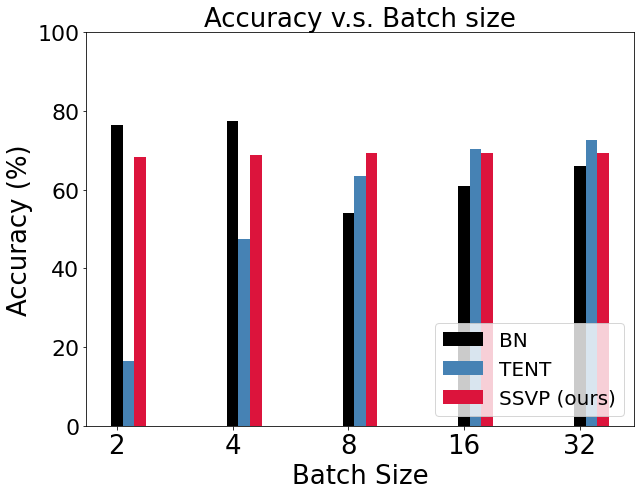

In [20]:
label_list=['BN','TENT', 'SSVP (ours)']
iter_list = [2, 4, 8, 16, 32]

plt.figure(figsize=(9,7))
plt.grid(False)

barWidth=0.1
br_list = []
br1 = np.arange(len(avg_result[0]))
br_list.append(br1)
for i in range(1,3):    
    br_list.append([x + barWidth for x in br_list[i-1]])

    

# plt.plot(br_list[0], np.repeat(orig_acc, 5), '--', color=colors['gray'], linewidth=2)

plt.bar(br_list[0], avg_result[0], color=colors['black'], width = barWidth, label=label_list[0])
# plt.plot(br_list[0], avg_result[0], '--', color=colors['black'], linewidth=2)
plt.bar(br_list[1], avg_result[1], color=colors['steelblue'], width = barWidth, label=label_list[1])
# plt.plot(br_list[1], avg_result[1], '--', color=colors['steelblue'], linewidth=2)
plt.bar(br_list[2], avg_result[2], color=colors['crimson'], width = barWidth, label=label_list[2])
# plt.plot(br_list[2], avg_result[2], '--', color=colors['crimson'], linewidth=2)
# plt.bar(br_list[3], result[3], color=colors['gray'], width = barWidth, label=label_list[3])
# plt.plot(br_list[3], result[3], '--', color=colors['gray'], linewidth=2)

# for i in range(len(avg_result)):
#     plt.plot(br_list[i], avg_result[i], '--', linewidth=2, label=label_list[i])

myticks = ["2", "4", "8", "16", "32"]
plt.xticks(br_list[0], myticks ,fontsize=26)
plt.yticks(fontsize=22)
plt.ylim(0,100)

plt.title('Accuracy v.s. Batch size', fontsize=26)
plt.xlabel('Batch Size', fontsize=26)
plt.ylabel('Accuracy (%)', fontsize=26)
plt.legend(fontsize=20, loc='lower right')

plt.tight_layout()
plt.savefig('./output/cifarc_digital_acc_batchsize.png', dpi=200)

NameError: name 'finetune_result' is not defined

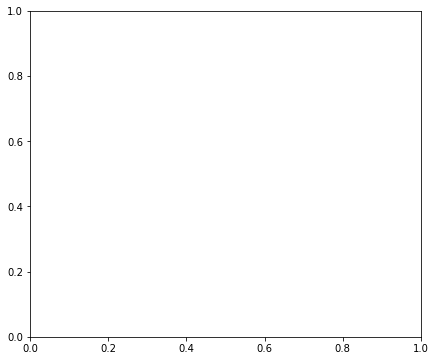

In [14]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
label_list=[ 'Finetune', 'VP (padding)', 'VP (patch)', 'CVP (ours)']
iter_list = [2, 4, 8, 16, 32]

plt.figure(figsize=(7,6))
plt.grid(False)

barWidth=0.15
br_list = []
br1 = np.arange(len(finetune_result))
br_list.append(br1)
for i in range(1,4):    
    br_list.append([x + barWidth for x in br_list[i-1]])

standard_result = [59.67,59.67,59.67,59.67,59.67]    
# c_list = ['green', 'blue', 'darkorange', 'blue', 'crimson']
# plt.plot(br_list[0], np.repeat(orig_acc, 5), '--', color=colors['gray'], linewidth=2)

# plt.bar(br_list[0], standard_result, color=colors['black'], width = barWidth, label=label_list[0])
plt.bar(br_list[0], finetune_result, color=colors['dimgray'], width = barWidth, label=label_list[0])
# plt.plot(br_list[0], avg_result[0], '--', color=colors['black'], linewidth=2)
plt.bar(br_list[1], l2_append_result, color=colors['orange'], width = barWidth, label=label_list[1])

plt.bar(br_list[2], l2_result, color=colors['skyblue'], width = barWidth, label=label_list[2])
# plt.plot(br_list[1], avg_result[1], '--', color=colors['steelblue'], linewidth=2)
plt.bar(br_list[3], conv_result, color=colors['crimson'], width = barWidth, label=label_list[3])
# plt.plot(br_list[2], avg_result[2], '--', color=colors['crimson'], linewidth=2)
# plt.bar(br_list[3], result[3], color=colors['gray'], width = barWidth, label=label_list[3])
# plt.plot(br_list[3], result[3], '--', color=colors['gray'], linewidth=2)

# for i in range(len(avg_result)):
#     plt.plot(br_list[i], avg_result[i], '--', linewidth=2, label=label_list[i])

myticks = ["2", "4", "8", "16", "32"]
plt.xticks(br_list[0], myticks ,fontsize=26)
plt.yticks(fontsize=22)
plt.ylim(0,100)

# plt.title('Accuracy v.s. Batch size', fontsize=26)
plt.xlabel('Batch Size', fontsize=26)
plt.ylabel('Accuracy (%)', fontsize=26)
plt.legend(fontsize=18, loc='upper right')

plt.tight_layout()
plt.savefig('./output/cifarc_acc_batchsize.png', dpi=200)

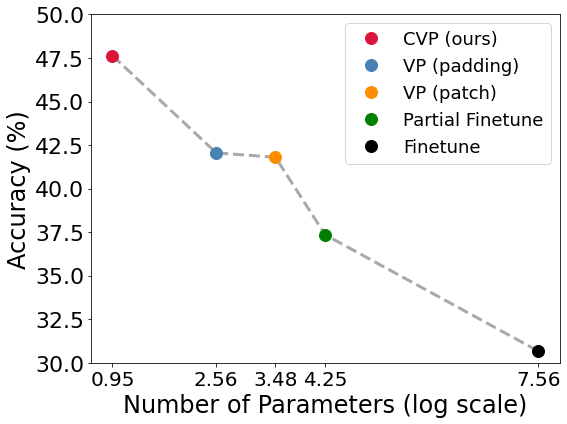

In [15]:
c = ['CVP (ours)', 'VP (padding)', 'VP (patch)', 'Partial Finetune', 'Finetune']
x = [9, 372, 3072, 17952, 36479194]
x = [0.95, 2.56,  3.48,  4.25, 7.56]
y = [47.63,  42.05, 41.80, 37.35, 30.67]

plt.figure(figsize=(8,6))
plt.grid(False)

marker = ['o', 'o', 'o', 'o', 'o']
color = ['crimson', 'steelblue', 'darkorange', 'green', 'black']
plt.plot(x, y, '--', color='darkgray', linewidth=3)
for i in range(len(x)):
    plt.plot(x[i], y[i], marker[i], label=c[i], markersize=12, color=colors[color[i]])

plt.legend()
# plt.title('Different Hybrid Prompts', fontsize=20)
plt.xlabel('Number of Parameters (log scale)', fontsize=24)
plt.ylabel('Accuracy (%)', fontsize=24)
plt.xticks(x, ['0.95', '2.56', '3.48', '4.25', '7.56'], fontsize=20)
plt.yticks(fontsize=22)
plt.ylim(30, 50)

plt.legend(fontsize=18, loc='upper right')
plt.tight_layout()
plt.savefig('./output/acc_vs_param.png', dpi=200)

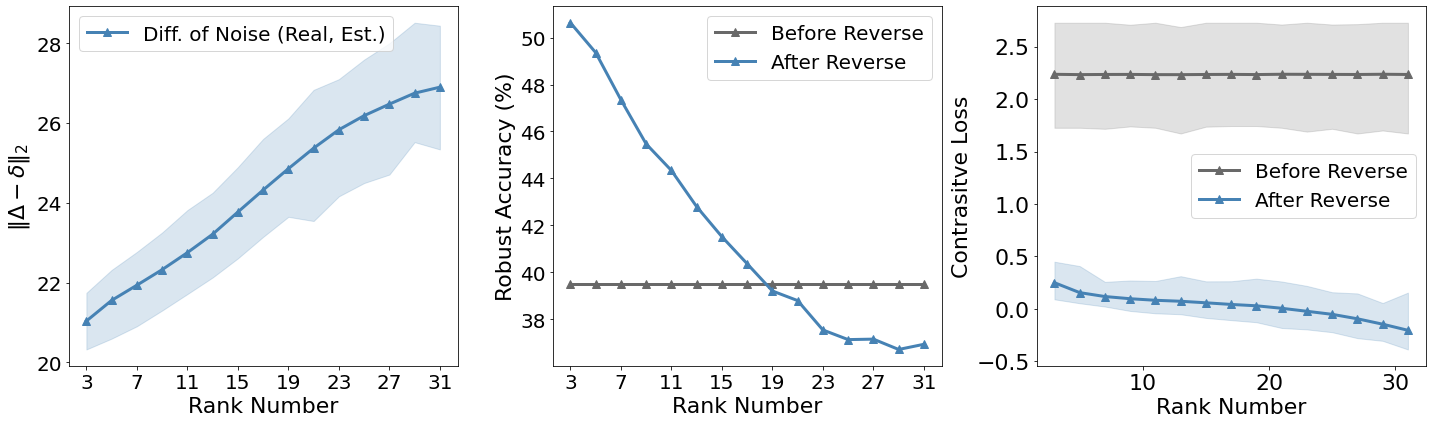

In [68]:
x = [3,5,7,9,11,13,15,17,19,21,23,25,27,29,31]
# plt.plot(x, y, '--', color='darkgray', linewidth=3)

before_loss = []
after_loss = []
norm_diff = []
for i in range(len(x)):
    l1, l2, diff = np.load('./output/cifar10c_lowrank_'+str(x[i])+'.npy')
    before_loss.append(l1)
    after_loss.append(l2)
    norm_diff.append(diff)

avg_norm_diff = np.array(norm_diff).mean(axis=1)
max_norm_diff = np.array(norm_diff).max(axis=1)
min_norm_diff = np.array(norm_diff).min(axis=1)

avg_before_loss = np.array(before_loss).mean(axis=1)
max_before_loss = np.array(before_loss).max(axis=1)
min_before_loss = np.array(before_loss).min(axis=1)

avg_after_loss = np.array(after_loss).mean(axis=1)
max_after_loss = np.array(after_loss).max(axis=1)
min_after_loss = np.array(after_loss).min(axis=1)


fig, axs = plt.subplots(1, 3, figsize=(20, 6))  

axs[0].plot(x, avg_norm_diff, '-', label='Diff. of Noise (Real, Est.)', marker='^', markersize=8, linewidth=3, color=colors['steelblue'])
axs[0].fill_between(x, min_norm_diff, max_norm_diff, color=colors['steelblue'], alpha=0.2)
# axs[0].plot(x, vp2_loss, '--', label='VP (25/255)', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
# axs[0].plot(x, vp3_loss, '--', label='VP', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
# axs[0].plot(x, scvp_loss, '--', label='CVP (ours)', marker='^', markersize=16, linewidth=3, color=colors['crimson'])
axs[0].tick_params(axis='both', which='major', labelsize=20)
# axs[].set_title(f'{corruption_name[i]}', fontsize=26)
axs[0].set_xlabel('Rank Number', fontsize=22)
a = r'$\Vert\Delta -\delta\Vert_2$'
axs[0].set_ylabel(a, fontsize=22)
axs[0].legend(loc='upper left', fontsize=20)
# axs[0].set_yticks((1.5, 2,2.5,3,3.5)) 
axs[0].set_xticks((3, 7, 11,15, 19,23, 27, 31)) 

acc1 = 0.3951
before_acc = np.tile(acc1*100, 15)
after_acc = [0.5063, 0.4936, 0.4735, 0.4547, 0.4434, 0.428, 0.4152, 0.4037, 0.3921, 0.388, 0.3755, 0.3714, 0.3716, 0.3672, 0.3694]
after_acc = np.array(after_acc) * 100

axs[1].plot(x, before_acc, '-', label='Before Reverse', marker='^', markersize=8, linewidth=3, color=colors['dimgray'])
axs[1].plot(x, after_acc, '-', label='After Reverse', marker='^', markersize=8, linewidth=3, color=colors['steelblue'])
# axs[0].plot(x, vp3_loss, '--', label='VP', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
# axs[0].plot(x, scvp_loss, '--', label='CVP (ours)', marker='^', markersize=16, linewidth=3, color=colors['crimson'])
axs[1].tick_params(axis='both', which='major', labelsize=20)
# axs[].set_title(f'{corruption_name[i]}', fontsize=26)
axs[1].set_xlabel('Rank Number', fontsize=22)
axs[1].set_ylabel('Robust Accuracy (%)', fontsize=22)
axs[1].legend(loc='upper right', fontsize=20)
# axs[0].set_yticks((1.5, 2,2.5,3,3.5)) 
axs[1].set_xticks((3, 7, 11,15, 19,23, 27, 31)) 

axs[2].plot(x, avg_before_loss, '-', label='Before Reverse', marker='^', markersize=8, linewidth=3, color=colors['dimgray'])
axs[2].fill_between(x, min_before_loss, max_before_loss, color=colors['dimgray'], alpha=0.2)
axs[2].plot(x, avg_after_loss, '-', label='After Reverse', marker='^', markersize=8, linewidth=3, color=colors['steelblue'])
axs[2].fill_between(x, min_after_loss, max_after_loss, color=colors['steelblue'], alpha=0.2)
# axs[1].plot(x, vp3_acc, '--', label='VP (1)', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
# axs[1].plot(x, scvp_acc, '--', label='CVP (ours)', marker='^', markersize=16, linewidth=3, color=colors['crimson'])
axs[2].tick_params(axis='both', which='major', labelsize=22)
# ax1[].set_title(f'{corruption_name[i]}', fontsize=26)
axs[2].set_xlabel('Rank Number', fontsize=22)
axs[2].set_ylabel('Contrasitve Loss', fontsize=22)
axs[2].legend(loc='center right', fontsize=20)
# axs[1].set_yticks((-0.5, 0, 0.1, 0.2)) 
# axs[1].set_xticks((0, 5,10 ,20,30)) 




plt.tight_layout()
plt.show()
# plt.savefig('./output/acc_vs_iter.png', dpi=200)


In [63]:
scvp_acc = [39.51, 51.09, 52.56, 53.41, 54.69, 56.1, 58.76, 59.30, 59.58]
scvp_loss = [3.51, 2.89, 2.78, 2.71, 2.67, 2.1, 1.9, 1.95, 1.92]

In [64]:
vp_acc = [39.51, 41.51, 43.72, 45.12, 46, 46.78, 48.62, 48.98, 48.26]
vp_loss = [3.51, 3.19, 3.06, 2.97, 2.90, 2.83, 2.70, 2.61, 2.54]

In [65]:
vp2_loss = [3.51, 2.85, 2.7,  2.65,2.4, 2.16, 2.1352, 2.1023, 2.12]
vp2_acc = [39.51, 39.78, 39.98, 40.57, 40.77, 40.97, 41.36, 41.07, 41.07]

In [66]:
vp3_loss = [3.51, 2.28, 2.22, 2.18, 2.14, 1.88, 1.56, 1.33, 1.32]
vp3_acc = [39.51, 38.98, 39.48,39.98, 40.27, 40.97, 43.84, 44.43, 44.25]

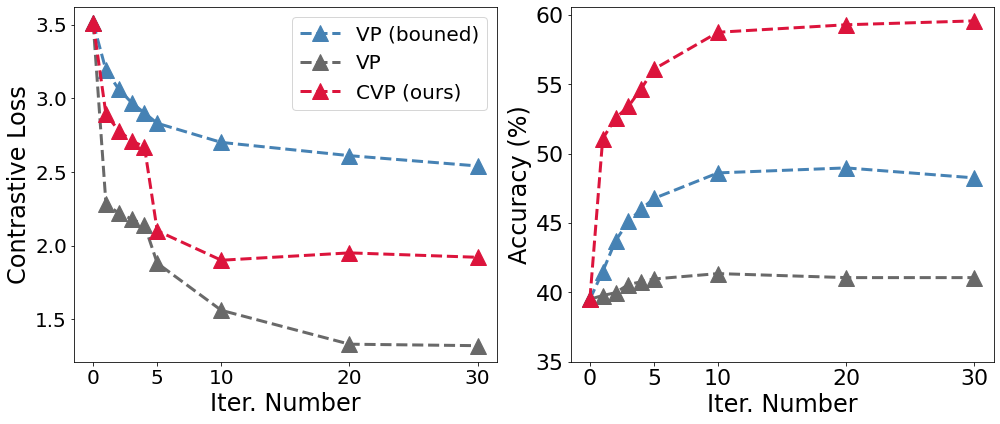

In [67]:
x = [0, 1, 2, 3, 4, 5, 10, 20, 30]
# plt.plot(x, y, '--', color='darkgray', linewidth=3)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))  



axs[0].plot(x, vp_loss, '--', label='VP (bouned)', marker='^', markersize=16, linewidth=3, color=colors['steelblue'])
# axs[0].plot(x, vp2_loss, '--', label='VP (25/255)', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
axs[0].plot(x, vp3_loss, '--', label='VP', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
axs[0].plot(x, scvp_loss, '--', label='CVP (ours)', marker='^', markersize=16, linewidth=3, color=colors['crimson'])
axs[0].tick_params(axis='both', which='major', labelsize=20)
# axs[].set_title(f'{corruption_name[i]}', fontsize=26)
axs[0].set_xlabel('Iter. Number', fontsize=24)
axs[0].set_ylabel('Contrastive Loss', fontsize=24)
axs[0].legend(loc='upper right', fontsize=20)
axs[0].set_yticks((1.5, 2,2.5,3,3.5)) 
axs[0].set_xticks((0, 5,10 ,20,30)) 

axs[1].plot(x, vp_acc, '--', label='VP (8/255)', marker='^', markersize=16, linewidth=3, color=colors['steelblue'])
axs[1].plot(x, vp2_acc, '--', label='VP (1)', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
# axs[1].plot(x, vp3_acc, '--', label='VP (1)', marker='^', markersize=16, linewidth=3, color=colors['dimgray'])
axs[1].plot(x, scvp_acc, '--', label='CVP (ours)', marker='^', markersize=16, linewidth=3, color=colors['crimson'])
axs[1].tick_params(axis='both', which='major', labelsize=22)
# ax1[].set_title(f'{corruption_name[i]}', fontsize=26)
axs[1].set_xlabel('Iter. Number', fontsize=24)
axs[1].set_ylabel('Accuracy (%)', fontsize=24)
# axs[1].legend(loc='lower right', fontsize=20)
axs[1].set_yticks((35,40,45,50,55,60)) 
axs[1].set_xticks((0, 5,10 ,20,30)) 




plt.tight_layout()
plt.savefig('./output/acc_vs_iter.png', dpi=200)

In [81]:
import os
import csv
filepath_list = ['./train_ssl/CIFAR10C_V2_OURS_log_1111_brightness.csv', 
                 './train_ssl/CIFAR10C_V2_OURS_log_1111_saturation.csv', 
                 './train_ssl/cifar10c_V2_contrast_log.csv',
                './train_ssl/cifar10c_V2_sharpness_log.csv']

result = []

for f in filepath_list:
    print(f)
    iter0_list = []
    iter1_list = []
    iter5_list = []
    iter10_list = []
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row[3] == '1' and int(row[6].split(": ")[1])==1:
                iter0_list.append(float(row[8]))
                iter1_list.append(float(row[9]))
            elif row[3] == '5' and int(row[6].split(": ")[1])==1:
                iter5_list.append(float(row[9]))
            elif row[3] == '10' and int(row[6].split(": ")[1])==1:
                iter10_list.append(float(row[9]))

    result.append([(1- sum(iter0_list)/15)*100, (1 - sum(iter1_list)/15)*100, (1 - sum(iter5_list)/15)*100, (1 - sum(iter10_list)/15)*100])
    

print(len(result))

./train_ssl/CIFAR10C_V2_OURS_log_1111_brightness.csv
./train_ssl/CIFAR10C_V2_OURS_log_1111_saturation.csv
./train_ssl/cifar10c_V2_contrast_log.csv
./train_ssl/cifar10c_V2_sharpness_log.csv
4


In [82]:
result

[[40.32, 61.21399999999999, 61.528000000000006, 60.937333333333335],
 [40.32, 44.82933333333333, 44.309999999999995, 44.472],
 [37.69066666666666, 59.101333333333336, 44.40333333333333, 44.80133333333334],
 [40.324666666666666, 37.78066666666666, 37.20199999999999, 37.21466666666667]]

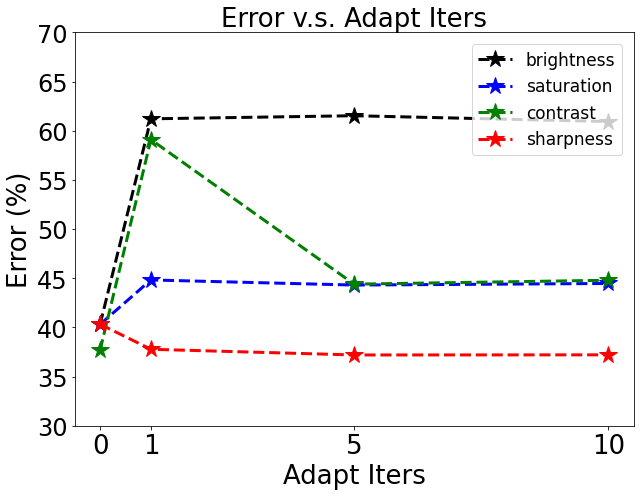

In [83]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
label_list=['brightness', 'saturation', 'contrast', 'sharpness']
iter_list = [0, 1, 5, 10]
plt.figure(figsize=(9,7))
plt.grid(False)

plt.plot(iter_list, result[0], '--', marker='*', markersize=18, color=colors['black'], linewidth=3, label=label_list[0])
plt.plot(iter_list, result[1], '--', marker='*', markersize=18, color=colors['blue'], linewidth=3, label=label_list[1])
plt.plot(iter_list, result[2], '--', marker='*', markersize=18, color=colors['green'], linewidth=3, label=label_list[2])
plt.plot(iter_list, result[3], '--', marker='*', markersize=18, color=colors['red'], linewidth=3, label=label_list[3])


myticks = ["0", "1", "5", "10"]

    
plt.xticks(iter_list, myticks ,fontsize=26)
plt.yticks(fontsize=24)
plt.ylim(30, 70)

plt.title('Error v.s. Adapt Iters', fontsize=26)
plt.xlabel('Adapt Iters', fontsize=26)
plt.ylabel('Error (%)', fontsize=26)
# plt.legend(fontsize=18, loc='upper left')
plt.legend(bbox_to_anchor=(0.98,0.97),loc="upper right", borderaxespad=0., fontsize=17)
plt.tight_layout()
plt.savefig('./output/imagnetc_semantic_compare.png', dpi=200)

In [84]:
import os
import csv
filepath_list = ['./train_ssl/cifar10c_V2_L2_log.csv', 
                 './train_ssl/cifar10c_V2_Linf_log.csv', 
                 './train_ssl/cifar10c_V2_OURS_Iter10_log.csv',
                './train_ssl/cifar10c_V2_Linf_sharpness_log.csv',
                './train_ssl/cifar10c_V2_sharpness_log.csv']

result = []

for f in filepath_list:
    print(f)
    iter0_list = []
    iter1_list = []
    iter5_list = []
    iter10_list = []
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row[3] == '1' and int(row[6].split(": ")[1])==1:
                iter0_list.append(float(row[8]))
                iter1_list.append(float(row[9]))
            elif row[3] == '5' and int(row[6].split(": ")[1])==1:
                iter5_list.append(float(row[9]))
            elif row[3] == '10' and int(row[6].split(": ")[1])==1:
                iter10_list.append(float(row[9]))

    result.append([(1- sum(iter0_list)/15)*100, (1 - sum(iter1_list)/15)*100, (1 - sum(iter5_list)/15)*100, (1 - sum(iter10_list)/15)*100])
    

print(len(result))

./train_ssl/cifar10c_V2_L2_log.csv


IndexError: list index out of range

In [30]:
result

array([[[91.81, 92.9 , 77.25, 81.74, 86.94],
        [90.17, 91.43, 35.66, 42.23, 47.14],
        [49.03, 49.57, 57.87, 65.92, 71.3 ],
        [74.75, 76.23, 45.68, 54.2 , 59.03]],

       [[19.  , 70.11, 85.31, 87.88, 91.98],
        [15.7 , 26.21, 42.82, 50.25, 53.1 ],
        [16.59, 55.59, 70.24, 76.51, 78.01],
        [14.12, 37.64, 55.51, 66.41, 67.3 ]],

       [[92.66, 92.51, 92.72, 92.75, 92.84],
        [89.12, 89.92, 90.61, 90.92, 90.94],
        [36.51, 37.09, 37.65, 37.61, 37.3 ],
        [55.19, 55.46, 56.09, 56.05, 56.21]]])

In [31]:
result = [[37.69066666666667, 37.18266666666668, 40.17133333333332, 40.08733333333333],
 [40.324666666666666, 46.70333333333333, 45.18333333333333, 44.76466666666668],
 [40.324666666666666, 35.73333333333334, 35.20866666666665, 36.08866666666667],
 [40.324666666666666, 42.088, 40.62266666666665, 42.554],
 [40.324666666666666, 37.78066666666666, 37.20199999999999, 37.21466666666667]]

IndexError: list index out of range

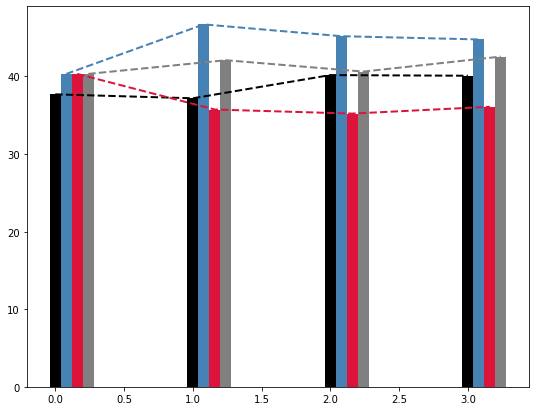

In [86]:
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
label_list=['l2', 'linf', 'l2 + sharpness (ours)', 'linf + sharpness', 'sharpness']
iter_list = [0, 1, 5, 10]
plt.figure(figsize=(9,7))
plt.grid(False)

barWidth=0.08
br_list = []
br1 = np.arange(len(result[0]))
br_list.append(br1)
for i in range(1,4):    
    br_list.append([x + barWidth for x in br_list[i-1]])

plt.bar(br_list[0], result[0], color=colors['black'], width = barWidth, label=label_list[0])
plt.plot(br_list[0], result[0], '--', color=colors['black'], linewidth=2)
plt.bar(br_list[1], result[1], color=colors['steelblue'], width = barWidth, label=label_list[1])
plt.plot(br_list[1], result[1], '--', color=colors['steelblue'], linewidth=2)
plt.bar(br_list[2], result[2], color=colors['crimson'], width = barWidth, label=label_list[2])
plt.plot(br_list[2], result[2], '--', color=colors['crimson'], linewidth=2)
plt.bar(br_list[3], result[3], color=colors['gray'], width = barWidth, label=label_list[3])
plt.plot(br_list[3], result[3], '--', color=colors['gray'], linewidth=2)
plt.bar(br_list[4], result[4], color=colors['gray'], width = barWidth, label=label_list[3])
plt.plot(br_list[4], result[4], '--', color=colors['gray'], linewidth=2)



myticks = ["0", "1", "5", "10"]

    
plt.xticks(br_list[0], myticks ,fontsize=26)
plt.yticks(fontsize=24)
plt.ylim(0, 70)

plt.title('Error v.s. SSVP Adapt Iters', fontsize=26)
plt.xlabel('SSVP Adapt Iters', fontsize=26)
plt.ylabel('Error (%)', fontsize=26)
plt.legend(fontsize=18, loc='upper left')

plt.tight_layout()
plt.savefig('./output/imagnetc_error_attckiters.png', dpi=200)

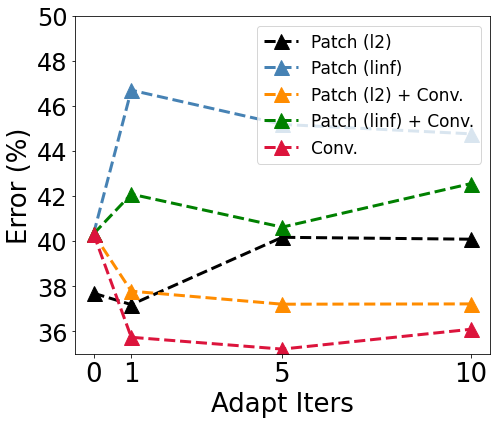

In [32]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
label_list=['Patch (l2)', 'Patch (linf)', 'Conv.', 'Patch (linf) + Conv.', 'Patch (l2) + Conv.']
iter_list = [0, 1, 5, 10]
plt.figure(figsize=(7,6))
plt.grid(False)

plt.plot(iter_list, result[0], '--', marker='^', markersize=15, color=colors['black'], linewidth=3, label=label_list[0])
plt.plot(iter_list, result[1], '--', marker='^', markersize=15, color=colors['steelblue'], linewidth=3, label=label_list[1])
plt.plot(iter_list, result[4], '--', marker='^', markersize=15, color=colors['darkorange'], linewidth=3, label=label_list[4])
plt.plot(iter_list, result[3], '--', marker='^', markersize=15, color=colors['green'], linewidth=3, label=label_list[3])
plt.plot(iter_list, result[2], '--', marker='^', markersize=15, color=colors['crimson'], linewidth=3, label=label_list[2])


myticks = ["0", "1", "5", "10"]

    
plt.xticks(iter_list, myticks ,fontsize=26)
plt.yticks(fontsize=24)
plt.ylim(35, 50)

# plt.title('Error v.s. Adapt Iters', fontsize=26)
plt.xlabel('Adapt Iters', fontsize=26)
plt.ylabel('Error (%)', fontsize=26)
# plt.legend(fontsize=18, loc='upper left')
plt.legend(bbox_to_anchor=(0.98,0.97),loc="upper right", borderaxespad=0., fontsize=17)
plt.tight_layout()
plt.savefig('./output/error_attckiters_v2.png', dpi=200)

In [118]:
swd = np.load('./output/imnetc_gaussian_noise_s1.npy')
print(swd.shape)
print(swd[0][2].mean())
print(swd[1][2].mean())

(2, 201, 201)
1006.25586
997.19293


In [ ]:
import os
import csv
filepath_list = ['./train_ssl/cifar10c_ssim_result.csv']

result = []

for f in filepath_list:
    print(f)
    iter0_list = []
    iter1_list = []
    iter5_list = []
    iter10_list = []
    with open(f, 'r') as file:
        csvreader = csv.reader(file)
        for row in csvreader:
            if row[6].split(": ")[1] == '1':
                print(row[5], row[6])
                before_ssim = float(row[10])
                after_ssim = float(row[11])
                print('ssim: {} {}'.format(before_ssim, after_ssim))

   

In [ ]:
from matplotlib import colors as mcolors
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)


source = [0.2256866667, 0.33304, 0.702785, 0.361045]
source = np.array(source)*100
ours = [0.25162, 0.42583, 0.69994, 0.390755]
ours = np.array(ours)*100
memo = [0.26984, 0.36748, 0.67283, 0.40215]
memo = np.array(memo)*100
memo_ours = [0.29888, 0.40916875, 0.65755625, 0.417865]
memo_ours = np.array(memo_ours)*100
norm = [0.5116133333, 0.570195,0.775565,0.576355]
norm = np.array(norm)*100
norm_ours = [0.5150066667, 0.564885, 0.77532, 0.57882]
norm_ours = np.array(norm_ours)*100
tent = [0.51156, 0.5702,0.775545,0.576295]
tent = np.array(tent)*100
tent_ours = [0.5604733333, 0.580465, 0.77901, 0.59444]
tent_ours = np.array(tent_ours)*100

fig = plt.figure(figsize =(10, 5))
barWidth=0.07
br_list = []
br1 = np.arange(len(source))
br_list.append(br1)
for i in range(1,8):    
    br_list.append([x + barWidth for x in br_list[i-1]])
print(br_list)
plt.bar(br_list[0], source, width = barWidth, color=colors['gray'], label='source')
plt.bar(br_list[1], ours, width = barWidth, color=colors['skyblue'], label='ours')
plt.bar(br_list[2], memo, width = barWidth, color=colors['darkred'], label='MEMO')
plt.bar(br_list[3], memo_ours, width = barWidth, color=colors['pink'], label='MEMO + ours')
plt.bar(br_list[4], norm, width = barWidth, color=colors['chocolate'], label='norm')
plt.bar(br_list[5], norm_ours, width = barWidth, color=colors['peachpuff'], label='norm + ours')
plt.bar(br_list[6], tent, width = barWidth, color=colors['steelblue'], label='TENT')
plt.bar(br_list[7], tent_ours, width = barWidth, color=colors['paleturquoise'], label='TENT + ours')

plt.xlabel("Corruption Type", fontsize=20)
plt.ylabel("Accuracy (%)", fontsize=20)

plt.xticks([r + 3*barWidth for r in range(4)],
        ['noise', 'blur', 'weather', 'digital'], fontsize=20)
plt.yticks(fontsize=18)
plt.legend(bbox_to_anchor=(0.5,1.23),loc="upper center", borderaxespad=0., ncol=4, fontsize=14)
plt.tight_layout()
plt.savefig('./output/imagnetc_corruption_acc.png', dpi=200)

In [ ]:
method_list = ['source', 'ours', 'memo', 'memo+ours', 'norm', 'norm+ours', 'tent', 'tent+ours']
noise_type = [0.2256866667, 0.25162, 0.26984, 0.29888, 0.5116133333, 0.5150066667, 0.51156, 0.5604733333]
blur_type = [0.33304, 0.42583, 0.36748, 0.40916875, 0.570195, 0.564885, 0.5702, 0.580465]
weather_type = [0.702785, 0.69994, 0.67283, 0.65755625, 0.775565, 0.77532, 0.775545, 0.77901]
digital_type = [0.361045, 0.390755, 0.40215, 0.417865, 0.576355, 0.578825, 0.576295, 0.59444]

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
# Horizontal Bar Plot
barWidth=0.05
br1 = np.arange(len(noise_type))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

plt.bar(br1, noise_type, width = barWidth, label = method_list)
plt.bar(br2, blur_type, width = barWidth, label = method_list)
plt.bar(br3, weather_type, width = barWidth, label = method_list)

plt.xlabel('Corruption Type', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(4)],
        ['noise', 'blur', 'weather', 'digital'])
# Show Plot
plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
pp = PdfPages('loss_distribution.pdf')

lcount_orig = np.zeros(500)
lcount_corr = np.zeros(500)
lcount_reverse = np.zeros(500)
for i in range(bin_orig_loss.shape[0]): lcount_orig[int(bin_orig_loss[i])] += 1
for i in range(bin_corr_loss.shape[0]): lcount_corr[int(bin_corr_loss[i])] += 1
for i in range(bin_reverse_loss.shape[0]): lcount_reverse[int(bin_reverse_loss[i])] += 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3), sharex=False, sharey=False)  
ax.plot(np.arange(500)*2/100, lcount_orig, label='clean')
ax.plot(np.arange(500)*2/100, lcount_corr, label='corrupt.')
ax.plot(np.arange(500)*2/100, lcount_reverse, label='reverse corrupt.')
ax.legend()
plt.title('corruption: gaussian noise')
plt.xlabel('discriminator loss')
plt.ylabel('number of sample')
plt.tight_layout()
plt.show()
# plt.savefig('loss_distribution.pdf') 
pp.savefig(fig)

pp.close()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

corruption_type = ['gaussian_noise', 'shot_noise','impulse_noise',
                      'defocus_blur', 'motion_blur' , 'glass_blur','zoom_blur','snow', 
                      'frost', 'fog', 'brightness', 'contrast', 'elastic_transform',
                      'pixelate', 'jpeg_compression']
all_tpr_fpr_list = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s1.npy', allow_pickle=True)
all_tpr_fpr_list_s3 = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s3.npy', allow_pickle=True)
all_tpr_fpr_list_s5 = np.load('./loss_histogram/cifar10_1_mixed_all_tpr_fpr_s5.npy', allow_pickle=True)
print(all_tpr_fpr_list.shape)
FPR_list = []
TPR_list = []
AUC_list = []

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))
fig.tight_layout() 
for i in range(15):

    tpr_fpr_list = all_tpr_fpr_list[i]
    ytrue = tpr_fpr_list[:,0]
    probs = tpr_fpr_list[:,1]   
    
    if i == 10:
        tpr_fpr_list = all_tpr_fpr_list_s5[i]
        ytrue = tpr_fpr_list[:,0]
        probs = tpr_fpr_list[:,1]

    auc = roc_auc_score(ytrue, probs)
    # summarize scores
    print('ROC AUC=%.3f' % (auc))
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(ytrue, probs)
    FPR_list.append(lr_fpr)
    TPR_list.append(lr_tpr)
    AUC_list.append(auc)
   

idx = 0
for j in range(3):
    for k in range(5):
        # plot the roc curve for the model
        axs[j, k].plot(FPR_list[idx], TPR_list[idx], marker='.', color='royalblue', label="auc = {0:0.3f}".format(AUC_list[idx]))
        axs[j, k].plot([0, 1], [0, 1], "k--")
        # axis labels
        axs[j, k].set_title(str(corruption_type[idx]))
#        axs[j, k].set_xlabel('False Positive Rate')
#        axs[j, k].set_ylabel('True Positive Rate')
        idx+=1
        # show the legend
        axs[j, k].legend()
            # show the plot
plt.show()
pp = PdfPages('cifar10c_all_roc_curve.pdf')
pp.savefig(fig)
pp.close()

In [ ]:
tpr_fpr_list_0 = all_tpr_fpr_list[0]
Ytrue = tpr_fpr_list_0[:,0]
Probs = tpr_fpr_list_0[:,1] 

tpr_fpr_list_s3_0 = all_tpr_fpr_list_s3[0]
Ytrue_s3 = tpr_fpr_list_s3_0[:,0]
Probs_s3 = tpr_fpr_list_s3_0[:,1] 

tpr_fpr_list_s5_0 = all_tpr_fpr_list_s5[0]
Ytrue_s5 = tpr_fpr_list_s5_0[:,0]
Probs_s5 = tpr_fpr_list_s5_0[:,1] 

for i in range(1, 15):
    tpr_fpr_list = all_tpr_fpr_list[i]
    tpr_fpr_list_s3 = all_tpr_fpr_list_s3[i]
    tpr_fpr_list_s5 = all_tpr_fpr_list_s5[i]
    
    ytrue = tpr_fpr_list[:,0]
    probs = tpr_fpr_list[:,1]
    
    ytrue_s3 = tpr_fpr_list_s3[:,0]
    probs_s3 = tpr_fpr_list_s3[:,1]
    
    ytrue_s5 = tpr_fpr_list_s5[:,0]
    probs_s5 = tpr_fpr_list_s5[:,1]

    Ytrue = np.concatenate((Ytrue, ytrue), axis=0)
    Probs = np.concatenate((Probs, probs), axis=0)
    
    Ytrue_s3 = np.concatenate((Ytrue_s3, ytrue_s3), axis=0)
    Probs_s3 = np.concatenate((Probs_s3, probs_s3), axis=0)
    
    Ytrue_s5 = np.concatenate((Ytrue_s5, ytrue_s5), axis=0)
    Probs_s5 = np.concatenate((Probs_s5, probs_s5), axis=0)

auc = roc_auc_score(Ytrue, Probs)
auc_s3 = roc_auc_score(Ytrue_s3, Probs_s3)
auc_s5 = roc_auc_score(Ytrue_s5, Probs_s5)
# summarize scores
print('s1 ROC AUC=%.3f' % (auc))
print('s3 ROC AUC=%.3f' % (auc_s3))
print('s5 ROC AUC=%.3f' % (auc_s5))
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(Ytrue, Probs)
lr_fpr_s3, lr_tpr_s3, thr = roc_curve(Ytrue_s3, Probs_s3)
lr_fpr_s5, lr_tpr_s5, _ = roc_curve(Ytrue_s5, Probs_s5)
# plot the roc curve for the model
print(thr[-1])
fig = plt.figure()
plt.plot(lr_fpr, lr_tpr, marker='.', color='royalblue', label="severity={0:0d} (auc = {1:0.4f})".format(1, auc))
plt.plot(lr_fpr_s3, lr_tpr_s3, marker='.', color='orange',  label="severity={0:0d} (auc = {1:0.4f})".format(3, auc_s3))
plt.plot(lr_fpr_s5, lr_tpr_s5, marker='.', color='green', label="severity={0:0d} (auc = {1:0.4f})".format(5, auc_s5))
plt.plot([0, 1], [0, 1], "k--")
# axis labels
plt.title('ROC curve on all CIFAR10-C')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
 
# plt.savefig('cifar10c_roc_curve.pdf', bbox_inches='tight')
pp1 = PdfPages('cifar10c_roccurve.pdf')
pp1.savefig(fig)
pp1.close()

In [ ]:
from imagecorruptions import get_corruption_names

data_dir = './data/'
np_image = np.load(data_dir + 'original.npy')
print(np_image.shape)
plt.title('Original')
plt.axis('off')
plt.imshow(np_image[1])
plt.show()
# for corruption in corruption_type:
#     co_list = []
#     for s in range(5):
#         corrupted_image = [corrupt(np_image[i], corruption_name=corruption, severity=s+1) for i in range(np_image.shape[0])]
#         co_list.append(corrupted_image)
#     print(np.array(co_list).shape)
#     file_path = data_dir + corruption + '.npy'
#     with open(file_path, 'wb') as f:
#         print('save corrupted image to : {}'.format(file_path))
#         np.save(f, np.array(co_list))
# print('finished to generate corrupted image!')

In [ ]:
class_map = {
    0 : 'airplane',
    1 : 'automobile', 
    2 : 'bird',
    3 : 'cat',
    4 : 'deer',
    5 : 'dog',
    6 : 'frog',
    7 : 'horse',
    8 : 'ship',
    9 : 'truck'
}

In [ ]:
def show_image(o_img, c_img, r_img, label, corr_pred, rev_pred):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4), sharex=True, sharey=True)  
    ax = axes.ravel()

    mse_none = mean_squared_error(o_img, o_img)
    ssim_none = ssim(o_img, o_img, multichannel=True, data_range=o_img.max() - o_img.min())
    cosim_none = cos_sim(o_img.ravel().reshape(1,-1), o_img.ravel().reshape(1,-1))[0][0]
#     print(mse_none, ssim_none, cosim_none)

    mse_corrupt = mean_squared_error(o_img, c_img)
    ssim_corrupt = ssim(o_img, c_img, multichannel=True, data_range=c_img.max() - c_img.min())
    cosim_corrupt = cos_sim(o_img.ravel().reshape(1,-1), c_img.ravel().reshape(1,-1))[0][0]
#     print(mse_corrupt, ssim_corrupt)

    mse_reverse = mean_squared_error(o_img, r_img)
    ssim_reverse = ssim(o_img, r_img, multichannel=True, data_range=r_img.max() - r_img.min())
    cosim_reverse = cos_sim(o_img.ravel().reshape(1,-1), r_img.ravel().reshape(1,-1))[0][0]
#     print(mse_reverse, ssim_reverse)

    ax[0].imshow(o_img)
    ax[0].set_xlabel(f'label: {class_map[label.item()]},\n MSE: {mse_none:.2f}, SSIM: {ssim_none:.2f}, cos_sim: {cosim_none:.2f}')
    ax[0].set_title('Original')

    ax[1].imshow(c_img)
    ax[1].set_xlabel(f'pred: {class_map[int(corr_pred)]},\n MSE: {mse_corrupt:.2f}, SSIM: {ssim_corrupt:.2f}, cos_sim: {cosim_corrupt:.2f}')
    ax[1].set_title('Image with corruption')

    ax[2].imshow(r_img)
    ax[2].set_xlabel(f'pred: {class_map[int(rev_pred)]},\n MSE: {mse_reverse:.2f}, SSIM: {ssim_reverse:.2f}, cos_sim: {cosim_reverse:.2f}')
    ax[2].set_title('Reversed image from corruption')

    plt.tight_layout()
    plt.show()

In [ ]:
def read_image(img_file, corrupted_img_array):
    
    severity = int(img_file.split("_")[1])
    idx = int(img_file.split("_")[3])
    corr_pred, rev_pred  = img_file.split("_")[5].split("-")
    param = img_file.split("_")[7].split(".npy")[0]
    label = test_ref['target'][idx]
    
    reversed_img = np.load(os.path.join(reversed_root_path, img_file))
    original_img = original_img_array[idx]
    corrupted_img = corrupted_img_array[severity][idx]

    o_img = img_as_float(original_img)
    c_img = img_as_float(corrupted_img)
    r_img = img_as_float(reversed_img)
    return o_img, c_img, r_img, label, corr_pred, rev_pred

In [ ]:
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics.pairwise import cosine_similarity as cos_sim
from skimage.metrics import mean_squared_error
from skimage import data, img_as_float


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_gaussian_noise.npy')

file_path2 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_gaussian_noise.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/gaussian_noise.npy')
reverse_success = np.load(file_path1, allow_pickle=True)
print(reverse_success[0].shape)
reverse_fail = np.load(file_path2, allow_pickle=True)
eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# fig = plt.figure()
# pp = PdfPages("./outputs/plots.pdf")
pp = PdfPages('cifar10c_reversed_sample.pdf')
for i in range(32,34):
    idx = reverse_success[i][0]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), sharex=False, sharey=False)  
    ax = axes.ravel()
    ax[0].axis('off')
    ax[0].imshow(original_img_array[idx])
    
    ax[0].set_title('original')
    
    ax[1].axis('off')
    ax[1].imshow(corrupted_img_array[1][idx])
    ax[1].set_title('corruption')
    
    ax[2].axis('off')
    ax[2].imshow(reverse_success[i][1])
    ax[2].set_title('reversed')
    if reverse_success[i][2][0] == reverse_success[i][4][0][0]:
        rmethod = 'contrast'
    if reverse_success[i][2][0] == reverse_success[i][4][1][0]:
        rmethod = 'sharpness'
    if reverse_success[i][2][0] == reverse_success[i][4][2][0]:
        rmethod = 'saturation'
    ax[2].set_xlabel(f'choice: {rmethod, np.round(reverse_success[i][2][0], decimals=2)}')

#     for j in range(3,6):  

#         param = (np.arange(20)/20) * (eps[j%3][1] - eps[j%3][0]) + eps[j%3][0]
#         ax[j].plot(param,reverse_success[i][3][j%3][0], label='dloss')
#         ax[j].plot(param, reverse_success[i][3][j%3][1], label='sloss')
#         ax[j].plot(param, reverse_success[i][3][j%3][2], label='joint')
#         ax[j].legend()
#         if j%3==0:
#             ax[j].set_title('contrast')
#         if j%3==1:
#             ax[j].set_title('sharpness')
#         if j%3==2:
#             ax[j].set_title('saturation')
       
    
    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#         x0,x1 = ax[j].get_xlim()
#         y0,y1 = ax[j].get_ylim()
#         ax[j].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.axis('off')
    plt.show()

# pp.close()
# plt.title('reversed')
   
# plt.imshow(img[3][0])
# print(loss_track[3][0])
# plt.figure()
# plt.plot(loss_track[3][0], label='loss trace')
# plt.legend()
# plt.show()
# for img_file in reversed_file:
#     print(img_file)
#     if img_file != 'old':
#         corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
#         o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)

    pp.savefig(fig)

pp.close()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'orig_success_loss_gaussian_noise.npy')

file_path2 = os.path.join(reversed_root_path, 'orig_fail_loss_gaussian_noise.npy')

file_path3 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_gaussian_noise.npy')

file_path4 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_gaussian_noise.npy')

file_path5 = os.path.join(reversed_root_path, 'clean_success_loss.npy')

file_path6 = os.path.join(reversed_root_path, 'clean_fail_loss.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/gaussian_noise.npy')
clean_success = np.load(file_path5, allow_pickle=True)
clean_fail = np.load(file_path6, allow_pickle=True)
orig_success = np.load(file_path1, allow_pickle=True)
orig_fail = np.load(file_path2, allow_pickle=True)
reverse_success = np.load(file_path3, allow_pickle=True)
reverse_fail = np.load(file_path4, allow_pickle=True)


aug = ['contrast', 'sharpness', 'saturation']
reverse_success_dloss = np.array([np.mean(reverse_success[i][3][0][aug.index(reverse_success[i][2][1])]) for i in range(reverse_success.shape[0])])
reverse_fail_dloss = np.array([np.mean(reverse_fail[i][3][0][aug.index(reverse_fail[i][2][1])]) for i in range(reverse_fail.shape[0])])

clean_success_arr = np.zeros((240))
clean_fail_arr = np.zeros((240))
count_success_arr = np.zeros((240))
count_fail_arr = np.zeros((240))
rcount_success_arr = np.zeros(240)
rcount_fail_arr = np.zeros(240)

for i in range(clean_success.shape[0]): clean_success_arr[int(np.round(clean_success[i]*100,0))] += 1
for i in range(clean_fail.shape[0]): clean_fail_arr[int(np.round(clean_fail[i]*100,0))] += 1    

for i in range(orig_success.shape[0]): count_success_arr[int(np.round(orig_success[i]*100,0))] += 1
for i in range(orig_fail.shape[0]): count_fail_arr[int(np.round(orig_fail[i]*100,0))] += 1
    
for i in range(reverse_success_dloss.shape[0]): rcount_success_arr[int(np.round(reverse_success_dloss[i]*100,0))] += 1
for i in range(reverse_fail_dloss.shape[0]): rcount_fail_arr[int(np.round(reverse_fail_dloss[i]*100,0))] += 1


eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# pp = PdfPages("./outputs/plots.pdf")
for i in range(0,1):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
    ax = axes.ravel()
#     ax[0].imshow(original_img_array[idx])
#     ax[0].set_title('original')

#     ax[1].imshow(corrupted_img_array[1][idx])
#     ax[1].set_title('corruption')

#     ax[2].imshow(reverse_success[i][1])
#     ax[2].set_title('reversed')
#     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


    x1 = (np.arange(240)/100)
    x2 = (np.arange(240)/100)
    ax[0].plot(x1, count_success_arr, label='success')  
    ax[0].plot(x1, count_fail_arr, label='fail')
    ax[0].legend()
    ax[0].set_title('corrupt. dloss')

    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#     x0,x1 = ax[0].get_xlim()
#     y0,y1 = ax[0].get_ylim()
#     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
      
    ax[1].plot(x2, rcount_success_arr, label='success')  
    ax[1].plot(x2, rcount_fail_arr, label='fail')
    ax[1].legend()
    ax[1].set_title('reverse dloss')
      
#     x0,x1 = ax[1].get_xlim()
#     y0,y1 = ax[1].get_ylim()
#     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    ax[2].plot(x2, clean_success_arr, label='success')  
    ax[2].plot(x2, clean_fail_arr, label='fail')
    ax[2].legend()
    ax[2].set_title('clean dloss')
      
#     x0,x1 = ax[2].get_xlim()
#     y0,y1 = ax[2].get_ylim()
#     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'clean_success_sloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'clean_fail_sloss_gaussian_noise.npy')
clean_success_sloss = np.load(file_path1, allow_pickle=True)
clean_fail_sloss = np.load(file_path2, allow_pickle=True)

clean_success_sloss = np.mean(clean_success_sloss, axis=-1)
clean_fail_sloss = np.mean(clean_fail_sloss, axis=-1)
print(clean_success_sloss.shape)
print(clean_fail_sloss.shape)

clean_count_success = np.zeros((3,350))
clean_count_fail = np.zeros((3,350))

for j in range(0,3):
    sloss_success = clean_success_sloss[:,j]
    print(sloss_success.shape)
    sloss_fail = clean_fail_sloss[:,j]
    print(sloss_fail.shape)
    for i in range(clean_success_sloss.shape[0]): clean_count_success[j][int(np.round(sloss_success[i]*100,0))] += 1
    for i in range(clean_fail_sloss.shape[0]): clean_count_fail[j][int(np.round(sloss_fail[i]*100,0))] += 1 
# pp = PdfPages("./outputs/plots.pdf")

for i in range(0,1):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
    ax = axes.ravel()
#     ax[0].imshow(original_img_array[idx])
#     ax[0].set_title('original')

#     ax[1].imshow(corrupted_img_array[1][idx])
#     ax[1].set_title('corruption')

#     ax[2].imshow(reverse_success[i][1])
#     ax[2].set_title('reversed')
#     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


    x1 = (np.arange(350)/100)
    x2 = (np.arange(350)/100)
    ax[0].plot(x1, clean_count_success[0], label='success')  
    ax[0].plot(x1, clean_count_fail[0], label='fail')
    ax[0].legend()
    ax[0].set_title('clean sloss')

    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
#     x0,x1 = ax[0].get_xlim()
#     y0,y1 = ax[0].get_ylim()
#     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
      
    ax[1].plot(x2, clean_count_success[1], label='success')  
    ax[1].plot(x2, clean_count_fail[1], label='fail')
    ax[1].legend()
    ax[1].set_title('clean sloss')
      
#     x0,x1 = ax[1].get_xlim()
#     y0,y1 = ax[1].get_ylim()
#     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
    
    ax[2].plot(x2, clean_count_success[2], label='success')  
    ax[2].plot(x2, clean_count_fail[2], label='fail')
    ax[2].legend()
    ax[2].set_title('clean sloss')
      
#     x0,x1 = ax[2].get_xlim()
#     y0,y1 = ax[2].get_ylim()
#     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'orig_success_allloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'orig_fail_allloss_gaussian_noise.npy')
success_loss = np.transpose(np.load(file_path1, allow_pickle=True), (1,0,2,3)) #dloss / sloss/ joinloss
fail_loss = np.transpose(np.load(file_path2, allow_pickle=True), (1,0,2,3))

loss_func = ['dloss', 'sloss', 'joint']
for k in range(0,3):

    reverse_success_loss = np.mean(success_loss[k], axis=-1)
    reverse_fail_loss = np.mean(fail_loss[k], axis=-1)
#     print(reverse_success_loss.shape)
#     print(reverse_fail_loss.shape)

    count_success = np.zeros((3,350))
    count_fail = np.zeros((3,350))

    for j in range(0,3):
        loss_success = reverse_success_loss[:,j]
#         print(loss_success.shape)
        loss_fail = reverse_fail_loss[:,j]
#         print(loss_fail.shape)
        for i in range(reverse_success_loss.shape[0]): count_success[j][int(np.round(loss_success[i]*100,0))] += 1
        for i in range(reverse_fail_loss.shape[0]): count_fail[j][int(np.round(loss_fail[i]*100,0))] += 1 
    # pp = PdfPages("./outputs/plots.pdf")

    for i in range(0,1):
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
        ax = axes.ravel()
    #     ax[0].imshow(original_img_array[idx])
    #     ax[0].set_title('original')

    #     ax[1].imshow(corrupted_img_array[1][idx])
    #     ax[1].set_title('corruption')

    #     ax[2].imshow(reverse_success[i][1])
    #     ax[2].set_title('reversed')
    #     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


        x1 = (np.arange(350)/100)
        x2 = (np.arange(350)/100)
        ax[0].plot(x1, count_fail[0], label='fail')
        ax[0].plot(x1, count_success[0], label='success') 
         

        ax[0].legend()
        ax[0].set_title('orig '+loss_func[k])

        #     ax[3].set_xticks(reverse_success[i][3][2])
        #     ax[3].set_xticklabels(param)

    #     x0,x1 = ax[0].get_xlim()
    #     y0,y1 = ax[0].get_ylim()
    #     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[1].plot(x2, count_fail[1], label='fail')
        ax[1].plot(x2, count_success[1], label='success') 

        

        ax[1].legend()
        ax[1].set_title('orig '+loss_func[k])

    #     x0,x1 = ax[1].get_xlim()
    #     y0,y1 = ax[1].get_ylim()
    #     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[2].plot(x2, count_fail[2], label='fail')
        ax[2].plot(x2, count_success[2], label='success')  
   
        

        ax[2].legend()
        ax[2].set_title('orig '+loss_func[k])

    #     x0,x1 = ax[2].get_xlim()
    #     y0,y1 = ax[2].get_ylim()
    #     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

    #     pp.savefig(fig)
        plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_allloss_gaussian_noise.npy')
file_path2 = os.path.join(reversed_root_path, 'reversed_fail_allloss_gaussian_noise.npy')
success_loss = np.transpose(np.load(file_path1, allow_pickle=True), (1,0,2,3)) #dloss / sloss/ joinloss
fail_loss = np.transpose(np.load(file_path2, allow_pickle=True), (1,0,2,3))

loss_func = ['dloss', 'sloss', 'joint']
for k in range(0,3):

    reverse_success_loss = np.mean(success_loss[k], axis=-1)
    reverse_fail_loss = np.mean(fail_loss[k], axis=-1)
#     print(reverse_success_loss.shape)
#     print(reverse_fail_loss.shape)

    count_success = np.zeros((3,450))
    count_fail = np.zeros((3,450))

    for j in range(0,3):
        loss_success = reverse_success_loss[:,j]
#         print(loss_success.shape)
        loss_fail = reverse_fail_loss[:,j]
#         print(loss_fail.shape)
        for i in range(reverse_success_loss.shape[0]): count_success[j][int(np.round(loss_success[i]*100,0))] += 1
        for i in range(reverse_fail_loss.shape[0]): count_fail[j][int(np.round(loss_fail[i]*100,0))] += 1 
    # pp = PdfPages("./outputs/plots.pdf")

    for i in range(0,1):
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4), sharex=False, sharey=False)  
        ax = axes.ravel()
    #     ax[0].imshow(original_img_array[idx])
    #     ax[0].set_title('original')

    #     ax[1].imshow(corrupted_img_array[1][idx])
    #     ax[1].set_title('corruption')

    #     ax[2].imshow(reverse_success[i][1])
    #     ax[2].set_title('reversed')
    #     ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')


        x1 = (np.arange(450)/100)
        x2 = (np.arange(450)/100)
        ax[0].plot(x1, count_fail[0], label='fail')
        ax[0].plot(x1, count_success[0], label='success')

          

        ax[0].legend()
        ax[0].set_title('reverse '+loss_func[k])

        #     ax[3].set_xticks(reverse_success[i][3][2])
        #     ax[3].set_xticklabels(param)

    #     x0,x1 = ax[0].get_xlim()
    #     y0,y1 = ax[0].get_ylim()
    #     ax[0].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[1].plot(x2, count_fail[1], label='fail')
        ax[1].plot(x2, count_success[1], label='success')  

       

        ax[1].legend()
        ax[1].set_title('reverse '+loss_func[k])

    #     x0,x1 = ax[1].get_xlim()
    #     y0,y1 = ax[1].get_ylim()
    #     ax[1].set_aspect(abs(x1-x0)/abs(y1-y0))
        ax[2].plot(x2, count_fail[2], label='fail')
        ax[2].plot(x2, count_success[2], label='success')  

        

        ax[2].legend()
        ax[2].set_title('reverse '+loss_func[k])

    #     x0,x1 = ax[2].get_xlim()
    #     y0,y1 = ax[2].get_ylim()
    #     ax[2].set_aspect(abs(x1-x0)/abs(y1-y0))

    #     pp.savefig(fig)
        plt.show()

In [ ]:
#### from matplotlib.backends.backend_pdf import PdfPages
reversed_root_path = './data/CIFAR-10-C-customize/reversed/'
reversed_file = os.listdir(reversed_root_path)
file_path1 = os.path.join(reversed_root_path, 'reversed_success_gan_joint_motion_blur.npy')

file_path2 = os.path.join(reversed_root_path, 'reversed_fail_gan_joint_motion_blur.npy')
# file_path2 = os.path.join(reversed_root_path, 'reversed_success.npy')

corrupted_img_array = np.load('./data/CIFAR-10-C-customize/motion_blur.npy')
reverse_success = np.load(file_path2, allow_pickle=True)

reverse_fail = np.load(file_path2, allow_pickle=True)
eps = [[0.1, 2.5], [0.1, 0.5], [0.7, 1.3]]

# pp = PdfPages("./outputs/plots.pdf")
for i in range(0,100):
    idx = reverse_success[i][0]
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(12, 3), sharex=False, sharey=False)  
    ax = axes.ravel()
    ax[0].imshow(original_img_array[idx])
    ax[0].set_title('original')

    ax[1].imshow(corrupted_img_array[1][idx])
    ax[1].set_title('corruption')

    ax[2].imshow(reverse_success[i][1])
    ax[2].set_title('reversed')
    ax[2].set_xlabel(f'choice: {reverse_success[i][2]},\n {reverse_success[i][4]}')

    for j in range(3,6):  

        param = (np.arange(20)/20) * (eps[j%3][1] - eps[j%3][0]) + eps[j%3][0]
        ax[j].plot(param,reverse_success[i][3][j%3][0], label='dloss')
        ax[j].plot(param, reverse_success[i][3][j%3][1], label='sloss')
        ax[j].plot(param, reverse_success[i][3][j%3][2], label='joint')
        ax[j].legend()
        ax[j].set_title('loss')
       
    
    #     ax[3].set_xticks(reverse_success[i][3][2])
    #     ax[3].set_xticklabels(param)
    
        x0,x1 = ax[j].get_xlim()
        y0,y1 = ax[j].get_ylim()
        ax[j].set_aspect(abs(x1-x0)/abs(y1-y0))

#     pp.savefig(fig)
    plt.show()

# pp.close()
# plt.title('reversed')
# plt.axis('off')
# plt.imshow(img[3][0])
# print(loss_track[3][0])
# plt.figure()
# plt.plot(loss_track[3][0], label='loss trace')
# plt.legend()
# plt.show()
# for img_file in reversed_file:
#     print(img_file)
#     if img_file != 'old':
#         corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
#         o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)

In [ ]:
import RandAugment
from pathlib import Path

reversed_root_path = './outputs/'
aug_name = 'contrast'
reversed_file = os.listdir(reversed_root_path)
pp = PdfPages("./outputs/loss_plots.pdf")
for img_file in reversed_file:
    f = os.path.join(reversed_root_path, img_file)
    path_f = Path(f)
    if path_f.is_file() and f.split(".")[-1]=='npy':
        ff = np.load(f, allow_pickle=True)
        imgs, accs, loss = ff[0], ff[1], ff[2]
        eps, rand_num = RandAugment.get_transAug_param(aug_name, 1)  
        param = (torch.arange(50)/50) * (eps[1] - eps[0]) + eps[0]

        fig =plt.figure(figsize=(10,5))
        #fig.subplots_adjust(bottom=0.025, left=0.025, top = 0.975, right=0.975)
        X = []
        for i in range (1,11):
            X.append((2,10,i))
        X.append((2,10,(11,20)))

        for nrows, ncols, plot_number in X: 
            sub = fig.add_subplot(nrows, ncols, plot_number)
            if type(plot_number) is tuple:
                sub.plot(param, loss, label='rotations task loss')
                sub.fill_between(param, np.min(np.array(loss)), np.max(np.array(loss)), where=np.array(accs) > 0,
                                color='green', alpha=0.3)
                sub.legend()
            else:
                sub.imshow(imgs[(plot_number-1)*(len(loss)//10)])
                sub.set_xticks([])
                sub.set_yticks([])
        plt.tight_layout()
        pp.savefig(fig)
        plt.show()
pp.close()

## Reverse CIFAR-10C contrast type corruption with contrast transformation

In [ ]:
reversed_root_path = './data/CIFAR-10-C-customize/reversed/contrast'
reversed_file = os.listdir(reversed_root_path)

for img_file in reversed_file:
    print(img_file)
    if img_file != 'old':
        corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
        o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)
        show_image(o_img, c_img, r_img, label, corr_pred, rev_pred)

## Reverse CIFAR-10C contrast type corruption with brightness transformation

In [ ]:
reversed_root_path = './data/CIFAR-10-C-customize/reversed/brightness'
reversed_file = os.listdir(reversed_root_path)

for img_file in reversed_file:
    print(img_file)
    corrupted_img_array = np.load('./data/CIFAR-10-C-customize/contrast.npy')
    o_img, c_img, r_img, label, corr_pred, rev_pred = read_image(img_file, corrupted_img_array)
    show_image(o_img, c_img, r_img, label, corr_pred, rev_pred)

T-SNE Visualization

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import time

def visualize_tsne(feature, group_ylabel):

    ft = [ft.numpy() for batch in feature for ft in batch ]
    ft = np.array(ft)
    print(ft.shape)
    feat_cols = [ 'pixel' + str(i) for i in range(ft.shape[1]) ]

    df = pd.DataFrame(ft,columns=feat_cols)
    df['y'] = group_ylabel
    df['label'] = df['y'].apply(lambda i: str(i))

    print('Size of the dataframe: {}'.format(df.shape))
    
    np.random.seed(42)
    rndperm = np.random.permutation(df.shape[0])

    df_subset = df.loc[rndperm[:],:].copy()
    data_subset = df_subset[feat_cols].values

    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data_subset)
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


    df_subset['tsne-2d-one'] = tsne_results[:,0]
    df_subset['tsne-2d-two'] = tsne_results[:,1]
#     plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", 11),
        data=df_subset,
        legend="full",
        alpha=0.3
    )